# Appendix: Alternative Models

We've seen that **Clinical Dementia Rating** (`CDRSB`), **Logical Memory Delayed Recall** (`LDELTOTAL`), and **Modified Digit Test** (`mPACCdigit`) are the most predictive parameters. However, **what happens if the dataset is heavily biased toward these features, but in reality they aren't that significant in predicting the diagnosis `DX`?** Let's create models that don't use these three features.

In [1]:

import os
import joblib
import pandas as pd
import shutil
import warnings

from CogniPredictAD.classification import ADNIClassifier, ADNIEvaluator, ADNI_run_gridsearch, save_xai_models
from CogniPredictAD.preprocessing import ADNIPreprocessor
from CogniPredictAD.visualization import Visualizer, ModelExplainer
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", message="X has feature names")

pd.set_option("display.max_rows", 116)
pd.set_option("display.max_columns", 40)
pd.set_option("display.max_info_columns", 40)

## Loading the Dataset
Open the training dataset with Pandas.

In [2]:
# Open the dataset with pandas
dataset = pd.read_csv("../data/pretrain.csv")
dataset.drop(columns=["CDRSB", "LDELTOTAL", "mPACCdigit"], inplace=True)
viz = Visualizer(dataset)
display(dataset.shape)
display(dataset)

(1934, 44)

DX   AGE  PTGENDER  PTEDUCAT  APOE4  ADAS11  ADAS13  ADASQ4  MMSE  \
0       AD  80.9         1        14    0.0   29.33   42.33    10.0  21.0   
1     LMCI  82.2         1        20    0.0   12.33   20.33     5.0  24.0   
2     LMCI  71.2         1        19    0.0    6.00    8.00     2.0  26.0   
3       CN  75.5         0        20    0.0    3.00    6.00     3.0  30.0   
4       CN  81.5         0        19    0.0    3.67    7.67     3.0  29.0   
...    ...   ...       ...       ...    ...     ...     ...     ...   ...   
1929  LMCI  64.6         0        14    2.0   12.00   22.00    10.0  27.0   
1930  LMCI  82.9         1        18    0.0   13.33   23.33     9.0  28.0   
1931  LMCI  76.8         1        12    0.0   11.33   16.33     4.0  25.0   
1932  LMCI  74.6         1        19    1.0   17.00   27.00    10.0  26.0   
1933  EMCI  72.7         1        14    1.0    8.00   15.00     7.0  26.0   

      RAVLT_immediate  RAVLT_learning  RAVLT_forgetting  \
0                15.0             1.0               3.0   
1                29.0             0.0               5.0   
2                51.0             2.0              -2.0   
3                61.0             7.0               3.0   
4                54.0             7.0               4.0   
...               ...             ...               ...   
1929             31.0             1.0               7.0   
1930             33.0             1.0               3.0   
1931             27.0             2.0               1.0   
1932             32.0             1.0               7.0   
1933             25.0             0.0               1.0   

      RAVLT_perc_forgetting  TRABSCOR   FAQ  mPACCtrailsB  Ventricles  \
0                  100.0000     300.0  19.0    -18.356400     62224.0   
1                   83.3333     155.0   4.0    -10.777900     85816.0   
2                  -18.1818     106.0   2.0     -6.457590     38223.0   
3                   20.0000      58.0   0.0      3.001880     61111.0   
4                   28.5714      54.0   0.0     -0.101632     44690.2   
...                     ...       ...   ...           ...         ...   
1929               100.0000      62.0   9.0     -9.369810     28016.0   
1930                42.8571      79.0   1.0     -7.013430     48243.3   
1931                16.6667     300.0   1.0    -10.624000     29502.0   
1932               100.0000     102.0   8.0    -10.521600     78282.0   
1933                25.0000     116.0   1.0     -7.956940     93560.0   

      Hippocampus  WholeBrain  Entorhinal  ...  EcogPtMem  EcogPtLang  \
0          5490.1   1062370.0      1514.0  ...    3.14286     3.00000   
1          5848.0   1114900.0      2222.0  ...        NaN         NaN   
2             NaN    953823.0         NaN  ...    2.75000     2.55556   
3          6691.0    923159.0      3760.0  ...    1.75000     1.33333   
4          5771.1    892350.0      3576.0  ...    1.87500     1.55556   
...           ...         ...         ...  ...        ...         ...   
1929       5561.0    970467.0      2723.0  ...        NaN         NaN   
1930       5074.9   1029360.0      2422.0  ...    2.12500     1.12500   
1931       8154.0    977778.0      4381.0  ...        NaN         NaN   
1932       5522.0   1227000.0      2028.0  ...    1.87500     1.33333   
1933       6868.0   1294960.0      4414.0  ...    2.12500     1.66667   

      EcogPtVisspat  EcogPtPlan  EcogPtOrgan  EcogPtDivatt  EcogPtTotal  \
0           3.00000         3.2      2.50000          2.75      2.94595   
1               NaN         NaN          NaN           NaN          NaN   
2           2.28571         3.2      3.83333          3.50      2.92308   
3           1.00000         1.0      1.16667          1.00      1.25641   
4           1.00000         1.0      1.33333          1.75      1.44737   
...             ...         ...          ...           ...          ...   
1929            NaN         NaN          NaN           NaN          NaN   
1930        1.16667 

## Split Class from Training Dataset

In [3]:
y_train = dataset['DX']
X_train = dataset.drop(columns=['DX'])

## ADNIPreprocessor Class

From the *Data Preprocessing notebook*, we developed a class that reproduces all its data-cleaning operations, ensuring consistent preprocessing for proper cross-validation evaluation.

**`ADNIPreprocessor`** is a scikit-learn–compatible transformer for ADNI data preprocessing. It detects and converts integer-like columns, scales and imputes missing values with KNN, creates safe ratio variables, and normalizes MRI measures by intracranial volume (ICV). It can also perform optional hybrid class balancing with undersampling and SMOTENC oversampling.

During fitting, the class computes means and standard deviations for numeric features and detects integer-like columns. The transform step applies imputation, integer conversion, ratio creation (`TAU/ABETA`, `PTAU/ABETA`), and MRI normalization, then removes redundant features. 

Core methods include `fit`, `transform`, `fit_transform`, and `get_feature_names_out`. 


In [4]:
preprocessing = ADNIPreprocessor()

## Grid Search

Our classification model choices will be: 

In [5]:
classifiers = {
    'Decision Tree': Pipeline([
        ('pre', preprocessing), 
        ('clf', DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=5))
    ]),
    'Random Forest': Pipeline([
        ('pre', preprocessing),
        ('clf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
    ]),
    'Extra Trees': Pipeline([
        ('pre', preprocessing),
        ('clf', ExtraTreesClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
    ]),
    'Adaptive Boosting': Pipeline([
        ('pre', preprocessing),
        ('clf', AdaBoostClassifier(random_state=42, estimator=DecisionTreeClassifier(class_weight='balanced')))
    ]),
    'Multinomial Logistic Regression': Pipeline([
        ('pre', preprocessing),
        ('scl', StandardScaler()), 
        ('clf', LogisticRegression(random_state=42, solver='saga', max_iter=2000, class_weight='balanced'))
    ])
}

We create the parameter grid to compare for the classifiers.

In [6]:
param_grids = {
    'Decision Tree': {
        'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_split': [2, 4, 8],
        'clf__min_samples_leaf': [2, 4, 8],
        'clf__ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.05]
    },
    'Random Forest': {
        'clf__n_estimators': [50, 75, 100],
        'clf__max_depth': [None, 6, 4],
        'clf__min_samples_leaf': [2, 4, 8],
        'clf__max_features': [0.5, 0.8, 1.0, 'sqrt'],
        'clf__criterion': ['gini', 'entropy']
    },
    'Extra Trees': {
        'clf__n_estimators': [50, 75, 100],
        'clf__max_depth': [None, 6, 4],
        'clf__min_samples_leaf': [2, 4, 8],
        'clf__max_features': [0.5, 0.8, 1.0, 'sqrt'],
        'clf__criterion': ['gini', 'entropy']
    },
    'Adaptive Boosting': {
        'clf__n_estimators': [50, 75, 100],
        'clf__learning_rate': [0.01, 0.05, 0.1,],
        'clf__estimator__max_depth': [None, 6, 4],
        'clf__estimator__min_samples_leaf': [2, 4, 8],
        'clf__estimator__criterion': ['gini', 'entropy']
    },
    'Multinomial Logistic Regression': {
        'clf__C': [0.01, 0.1, 1.0, 10.0],
        'clf__penalty': ['l1', 'l2']
    }
}


We will do **5-fold cross validation**.

In [7]:
n_cross_validation = 5

Now let's run the Grid Search (this will take a while).

### No Sampling

We use the **F1 macro** score. It evaluates the unweighted average of the F1s per class, forcing the grid search to look for hyperparameters that balance precision/recall across all classes (it avoids optimizing a model that only "exploits" sparse features to predict the majority class). 

In [8]:
bmc = ADNI_run_gridsearch(X_train=X_train, y_train=y_train, pipelines=classifiers, param_grids=param_grids, cv = n_cross_validation, scoring='f1_macro')


Running GridSearch for Decision Tree ...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best params for Decision Tree: {'clf__ccp_alpha': 0.01, 'clf__criterion': 'gini', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}
Best f1_macro: 0.6634
Decision Tree CV scores: [0.6616747  0.66439777 0.66621641 0.64359736 0.6811142 ]

Running GridSearch for Random Forest ...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params for Random Forest: {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__max_features': 0.8, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 100}
Best f1_macro: 0.7005
Random Forest CV scores: [0.66009633 0.72087183 0.70828599 0.72006806 0.69325448]

Running GridSearch for Extra Trees ...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params for Extra Trees: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': 0.8, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 100}
Best f1_macro: 0.706

### Sampling

We use the **F1 macro** score. Accuracy becomes meaningless because balancing alters the original distribution, thus not reflecting actual performance. F1 macro score evaluates precision and recall for each class separately, gives equal weight to all classes, and is not affected by artificial balancing. 

We re-write the pipelines for the sampling. 

In [9]:
categorical_features = [
    X_train.columns.get_loc("PTGENDER"),
    X_train.columns.get_loc("APOE4")
]

# Total number of rows in the fold
n_total_fold = (len(X_train) // n_cross_validation) * (n_cross_validation - 1)
n_per_class = n_total_fold // 4

# Undersampling strategy: only for classes larger than target_count
undersample_dict = {"CN": n_per_class, "LMCI": n_per_class}

# Oversampling strategy: only for classes smaller than target_count
oversample_dict = {"EMCI": n_per_class, "AD": n_per_class}

classifiers = {
    'Decision Tree': Pipeline([
        ('pre', preprocessing), 
        ('rus', RandomUnderSampler(sampling_strategy=undersample_dict, random_state=42)),
        ('smotenc', SMOTENC(categorical_features=categorical_features, sampling_strategy=oversample_dict, random_state=42)),
        ('clf', DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=5))
    ]),
    'Random Forest': Pipeline([
        ('pre', preprocessing),
        ('rus', RandomUnderSampler(sampling_strategy=undersample_dict, random_state=42)),
        ('smotenc', SMOTENC(categorical_features=categorical_features, sampling_strategy=oversample_dict, random_state=42)),
        ('clf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
    ]),
    'Extra Trees': Pipeline([
        ('pre', preprocessing),
        ('rus', RandomUnderSampler(sampling_strategy=undersample_dict, random_state=42)),
        ('smotenc', SMOTENC(categorical_features=categorical_features, sampling_strategy=oversample_dict, random_state=42)),
        ('clf', ExtraTreesClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
    ]),
    'Adaptive Boosting': Pipeline([
        ('pre', preprocessing),
        ('rus', RandomUnderSampler(sampling_strategy=undersample_dict, random_state=42)),
        ('smotenc', SMOTENC(categorical_features=categorical_features, sampling_strategy=oversample_dict, random_state=42)),
        ('clf', AdaBoostClassifier(random_state=42, estimator=DecisionTreeClassifier(class_weight='balanced')))
    ]),
    'Multinomial Logistic Regression': Pipeline([
        ('pre', preprocessing),
        ('scl', StandardScaler()),
        ('rus', RandomUnderSampler(sampling_strategy=undersample_dict, random_state=42)),
        ('smotenc', SMOTENC(categorical_features=categorical_features, sampling_strategy=oversample_dict, random_state=42)), 
        ('clf', LogisticRegression(random_state=42, solver='saga', max_iter=2000, class_weight='balanced'))
    ])
}


Then we start the Grid Search (this will take a while). 

In [10]:
bmcs = ADNI_run_gridsearch(X_train=X_train, y_train=y_train, pipelines=classifiers, param_grids=param_grids, cv = n_cross_validation, scoring='f1_macro')


Running GridSearch for Decision Tree ...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best params for Decision Tree: {'clf__ccp_alpha': 0.01, 'clf__criterion': 'entropy', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2}
Best f1_macro: 0.6582
Decision Tree CV scores: [0.64324175 0.65678237 0.66378117 0.67668041 0.65057127]

Running GridSearch for Random Forest ...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params for Random Forest: {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 100}
Best f1_macro: 0.7028
Random Forest CV scores: [0.69958304 0.68505108 0.72177692 0.71915009 0.68865262]

Running GridSearch for Extra Trees ...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params for Extra Trees: {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__max_features': 1.0, 'clf__min_samples_leaf': 8, 'clf__n_estimators': 100}
Best f1_macro: 0.704

We will choose this hyperparameters. 

In [11]:
# No Sampling
classifiers_3 = {
    'Decision Tree': DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced',
        criterion='gini',
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=2,
        ccp_alpha=0.01
    ),

    'Random Forest': RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1,
        criterion='gini',
        max_depth=6,
        max_features=0.8,
        min_samples_leaf=2,
        n_estimators=100
    ),

    'Extra Trees': ExtraTreesClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1,
        criterion='gini',
        max_depth=None,
        max_features=0.8,
        min_samples_leaf=4,
        n_estimators=100
    ),

    'Adaptive Boosting': AdaBoostClassifier(
        random_state=42,
        estimator=DecisionTreeClassifier(
            class_weight='balanced',
            criterion='gini',
            max_depth=6,
            min_samples_leaf=8
        ),
        learning_rate=0.05,
        n_estimators=100
    ),

    'Multinomial Logistic Regression': Pipeline([
        ('scl', StandardScaler()),
        ('clf', LogisticRegression(
            random_state=42,
            solver='saga',
            max_iter=2000,
            class_weight='balanced',
            penalty='l2',
            C=1.0
        ))
    ])
}


# Sampling
classifiers_4 = {
    'Decision Tree Sampled': DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced',
        criterion='entropy',
        max_depth=5,
        min_samples_split=2,
        min_samples_leaf=2,
        ccp_alpha=0.01
    ),

    'Random Forest Sampled': RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1,
        criterion='gini',
        max_depth=6,
        max_features=0.5,
        min_samples_leaf=4,
        n_estimators=100
    ),

    'Extra Trees Sampled': ExtraTreesClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1,
        criterion='gini',
        max_depth=6,
        max_features=1.0,
        min_samples_leaf=8,
        n_estimators=100
    ),

    'Adaptive Boosting Sampled': AdaBoostClassifier(
        random_state=42,
        estimator=DecisionTreeClassifier(
            class_weight='balanced',
            criterion='gini',
            max_depth=6,
            min_samples_leaf=2
        ),
        learning_rate=0.05,
        n_estimators=50
    ),

    'Multinomial Logistic Regression Sampled': Pipeline([
        ('scl', StandardScaler()),
        ('clf', LogisticRegression(
            random_state=42,
            solver='saga',
            max_iter=2000,
            class_weight='balanced',
            penalty='l2',
            C=1.0
        ))
    ])
}


## Classification Models


In [12]:
train = pd.read_csv("../data/train.csv")
train.drop(columns=["CDRSB", "LDELTOTAL", "mPACCdigit"], inplace=True)
sampled = pd.read_csv("../data/sampled.csv")
sampled.drop(columns=["CDRSB", "LDELTOTAL", "mPACCdigit"], inplace=True)

display(train)

DX  AGE  PTGENDER  PTEDUCAT  APOE4  MMSE  ADAS13  FAQ  MOCA  TRABSCOR  \
0       AD   80         1        14      0    21      42   19    13       300   
1     LMCI   82         1        20      0    24      20    4    20       155   
2     LMCI   71         1        19      0    26       8    2    25       106   
3       CN   75         0        20      0    30       6    0    26        58   
4       CN   81         0        19      0    29       8    0    29        54   
...    ...  ...       ...       ...    ...   ...     ...  ...   ...       ...   
1929  LMCI   64         0        14      2    27      22    9    22        62   
1930  LMCI   82         1        18      0    28      23    1    25        79   
1931  LMCI   76         1        12      0    25      16    1    22       300   
1932  LMCI   74         1        19      1    26      27    8    21       102   
1933  EMCI   72         1        14      1    26      15    1    24       116   

      RAVLT_immediate  RAVLT_learning  RAVLT_perc_forgetting  EcogPtMem  \
0                  15               1               100.0000    3.14286   
1                  29               0                83.3333    2.10000   
2                  51               2               -18.1818    2.75000   
3                  61               7                20.0000    1.75000   
4                  54               7                28.5714    1.87500   
...               ...             ...                    ...        ...   
1929               31               1               100.0000    2.97500   
1930               33               1                42.8571    2.12500   
1931               27               2                16.6667    1.60000   
1932               32               1               100.0000    1.87500   
1933               25               0                25.0000    2.12500   

      EcogPtLang  EcogPtVisspat  EcogPtPlan  EcogPtOrgan  EcogPtDivatt  \
0       3.000000       3.000000    3.200000     2.500000          2.75   
1       1.780554       1.274284    1.373334     1.699998          1.65   
2       2.555560       2.285710    3.200000     3.833330          3.50   
3       1.333330       1.000000    1.000000     1.166670          1.00   
4       1.555560       1.000000    1.000000     1.333330          1.75   
...          ...            ...         ...          ...           ...   
1929    1.930556       1.585714    1.400000     1.416668          1.95   
1930    1.125000       1.166670    2.000000     2.500000          2.00   
1931    1.533332       1.219048    1.040000     1.133334          1.45   
1932    1.333330       1.000000    1.200000     1.333330          1.00   
1933    1.666670       1.000000    1.000000     1.166670          2.00   

      EcogSPMem  EcogSPLang  EcogSPVisspat  EcogSPPlan  EcogSPOrgan  \
0      4.000000    3.444440       2.666670    3.000000     3.666670   
1      2.950000    2.530556       2.014286    1.756666     2.316666   
2      1.510714    1.266666       1.438096    1.760000     1.680000   
3      1.000000    1.000000       1.000000    1.000000     1.000000   
4      1.375000    1.111110       1.000000    1.200000     1.166670   
...         ...         ...            ...         ...          ...   
1929   3.025000    1.955554       1.671428    1.600000     1.866666   
1930   2.625000    1.625000       1.166670    1.400000     1.833330   
1931   2.100000    1.322222       1.657144    1.400000     1.366666   
1932   3.125000    2.875000       1.857140    1.333330     2.250000   
1933   1.750000    1.714290       1.200000    1.250000     1.000000   

      EcogSPDivatt       FDG  TAU/ABETA  PTAU/ABETA  Hippocampus/ICV  \
0             3.75  1.042620   0.630939    0.061115         0.003517   
1             2.75  1.080580   0.421770    0.041719         0.003360   
2             1.85  1.414550   0.182691    0.016757         0.005090   
3             1.00  1.118820   0.263255    0.024724         0.004908   
4             1.75  1.270141   0

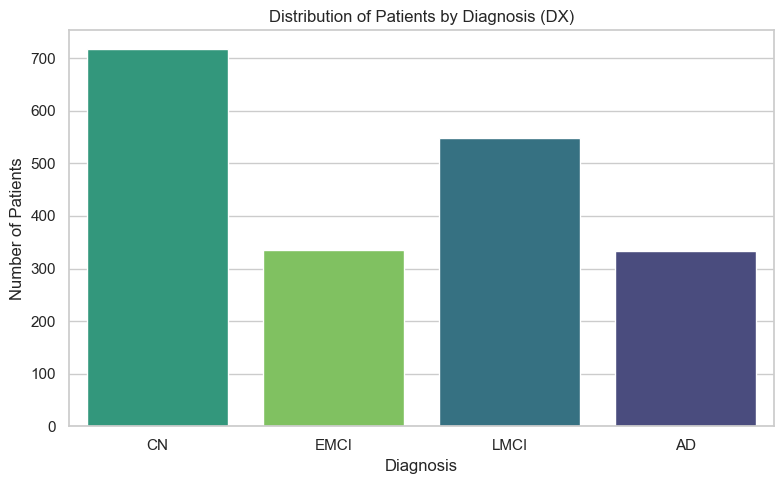

In [13]:
viz = Visualizer(train)
viz.count_plot(
    x="DX",
    figsize=(8, 5),
    palette="viridis",
    order = ["CN", "EMCI", "LMCI", "AD"],
    xlabel="Diagnosis",
    ylabel="Number of Patients",
    title="Distribution of Patients by Diagnosis (DX)"
)

We already see that: 
- CN:   717 -> 37.07%
- EMCI: 336 -> 17.37%
- LMCI: 548 -> 28.34%
- AD:   333 -> 17.22%

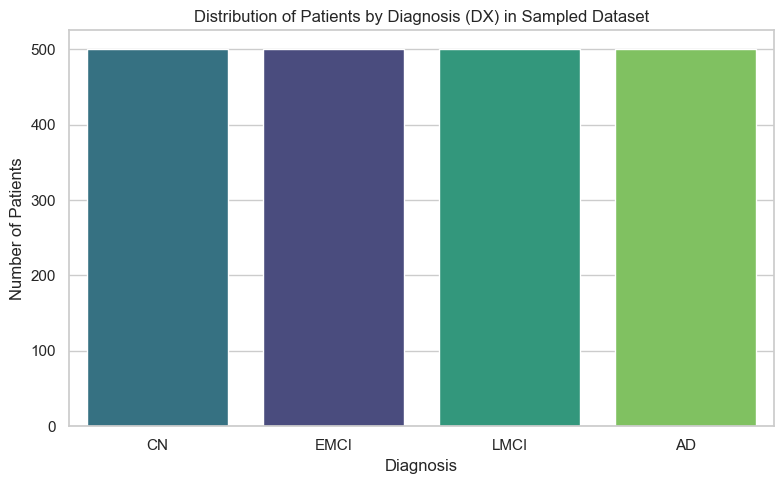

In [14]:
viz = Visualizer(sampled)
viz.count_plot(
    x="DX",
    figsize=(8, 5),
    palette="viridis",
    order = ["CN", "EMCI", "LMCI", "AD"],
    xlabel="Diagnosis",
    ylabel="Number of Patients",
    title="Distribution of Patients by Diagnosis (DX) in Sampled Dataset"
)

In [15]:
pretrain = pd.read_csv("../data/pretrain.csv")
pretrain.drop(columns=["CDRSB", "LDELTOTAL", "mPACCdigit"], inplace=True)

# Target column
y_train = pretrain['DX']

# All other columns as features
X_train = pretrain.drop(columns=['DX'])

## Model Creation

Training & Evaluating: Decision Tree
Training & Evaluating: Random Forest
Training & Evaluating: Extra Trees
Training & Evaluating: Adaptive Boosting
Training & Evaluating: Multinomial Logistic Regression
Training & Evaluating: Decision Tree Sampled
Training & Evaluating: Random Forest Sampled
Training & Evaluating: Extra Trees Sampled
Training & Evaluating: Adaptive Boosting Sampled
Training & Evaluating: Multinomial Logistic Regression Sampled


Model  F1 Score (macro)  Accuracy  \
2                              Extra Trees          0.705956  0.725957   
1                            Random Forest          0.699508  0.712685   
7                      Extra Trees Sampled          0.698837  0.713375   
6                    Random Forest Sampled          0.698488  0.708549   
4          Multinomial Logistic Regression          0.696534  0.710789   
9  Multinomial Logistic Regression Sampled          0.689613  0.703723   
3                        Adaptive Boosting          0.683303  0.704412   
8                Adaptive Boosting Sampled          0.682952  0.695967   
5                    Decision Tree Sampled          0.662868  0.670458   
0                            Decision Tree          0.645751  0.650121   

   Balanced Accuracy  Precision (weighted)  Recall (weighted)  \
2           0.703211              0.722339           0.725957   
1           0.698691              0.718661           0.712685   
7           0.702578              0.719488           0.713375   
6           0.700379              0.720980           0.708549   
4           0.703665              0.714868           0.710789   
9           0.696589              0.709482           0.703723   
3           0.683383              0.701644           0.704412   
8           0.685507              0.704626           0.695967   
5           0.664229              0.689962           0.670458   
0           0.652907              0.677733           0.650121   

   F1 Score (weighted)  ROC AUC (macro)  
2             0.723679         0.905522  
1             0.715140         0.897799  
7             0.714626         0.901032  
6             0.713039         0.899470  
4             0.711064         0.898761  
9             0.704708         0.896488  
3             0.702773         0.890973  
8             0.699098         0.887699  
5             0.677401         0.858902  
0             0.657591         0.840910

Model Class  Precision    Recall  \
0                             Decision Tree    CN   0.790298  0.727104   
1                             Decision Tree  EMCI   0.380456  0.579365   
2                             Decision Tree  LMCI   0.630603  0.496350   
3                             Decision Tree    AD   0.812877  0.808809   
4                             Random Forest    CN   0.800279  0.801023   
5                             Random Forest  EMCI   0.469244  0.529762   
6                             Random Forest  LMCI   0.681467  0.644161   
7                             Random Forest    AD   0.855799  0.819820   
8                               Extra Trees    CN   0.794939  0.847048   
9                               Extra Trees  EMCI   0.521097  0.490079   
10                              Extra Trees  LMCI   0.674827  0.653893   
11                              Extra Trees    AD   0.847265  0.821822   
12                        Adaptive Boosting    CN   0.785905  0.819154   
13                        Adaptive Boosting  EMCI   0.466127  0.457341   
14                        Adaptive Boosting  LMCI   0.666027  0.633212   
15                        Adaptive Boosting    AD   0.816468  0.823824   
16          Multinomial Logistic Regression    CN   0.806527  0.804277   
17          Multinomial Logistic Regression  EMCI   0.486695  0.562500   
18          Multinomial Logistic Regression  LMCI   0.687943  0.590024   
19          Multinomial Logistic Regression    AD   0.792052  0.857858   
20                    Decision Tree Sampled    CN   0.787953  0.748024   
21                    Decision Tree Sampled  EMCI   0.397210  0.536706   
22                    Decision Tree Sampled  LMCI   0.652114  0.572384   
23                    Decision Tree Sampled    AD   0.836649  0.799800   
24                    Random Forest Sampled    CN   0.809684  0.785216   
25                    Random Forest Sampled  EMCI   0.458861  0.575397   
26                    Random Forest Sampled  LMCI   0.690444  0.624088   
27                    Random Forest Sampled    AD   0.844720  0.816817   
28                      Extra Trees Sampled    CN   0.800913  0.815435   
29                      Extra Trees Sampled  EMCI   0.461993  0.542659   
30                      Extra Trees Sampled  LMCI   0.705000  0.600365   
31                      Extra Trees Sampled    AD   0.827821  0.851852   
32                Adaptive Boosting Sampled    CN   0.801328  0.785681   
33                Adaptive Boosting Sampled  EMCI   0.444996  0.533730   
34                Adaptive Boosting Sampled  LMCI   0.667790  0.602798   
35                Adaptive Boosting Sampled    AD   0.819000  0.819820   
36  Multinomial Logistic Regression Sampled    CN   0.804603  0.796374   
37  Multinomial Logistic Regression Sampled  EMCI   0.468067  0.552579   
38  Multinomial Logistic Regression Sampled  LMCI   0.683014  0.584550   
39  Multinomial Logistic Regression Sampled    AD   0.791822  0.852853   

    F1 Score  Support  
0   0.757385   2151.0  
1   0.459300   1008.0  
2   0.555480   1644.0  
3   0.810838    999.0  
4   0.800651   2151.0  
5   0.497670   1008.0  
6   0.662289   1644.0  
7   0.837423    999.0  
8   0.820167   2151.0  
9   0.505112   1008.0  
10  0.664195   1644.0  
11  0.834350    999.0  
12  0.802185   2151.0  
13  0.461693   1008.0  
14  0.649205   1644.0  
15  0.820130    999.0  
16  0.805400   2151.0  
17  0.521859   1008.0  
18  0.635232   1644.0  
19  0.823642    999.0  
20  0.767470   2151.0  
21  0.456540   1008.0  
22  0.609653   1644.0  
23  0.817810    999.0  
24  0.797262   2151.0  
25  0.510563   1008.0  
26  0.655591   1644.0  
27  0.830534    999.0  
28  0.808109   2151.0  
29  0.499088   1008.0  
30  0.648489   1644.0  
31  0.839665    999.0  
32  0.793427   2151.0  
33  0.485341   1008.0  
34  0.633632   1644.0  
35  0.819410    999.0  
36  0.800467   2151.0  
37  0.506824   1008.0  
38  0.629957   1644.0  
39  0.821205    999.0

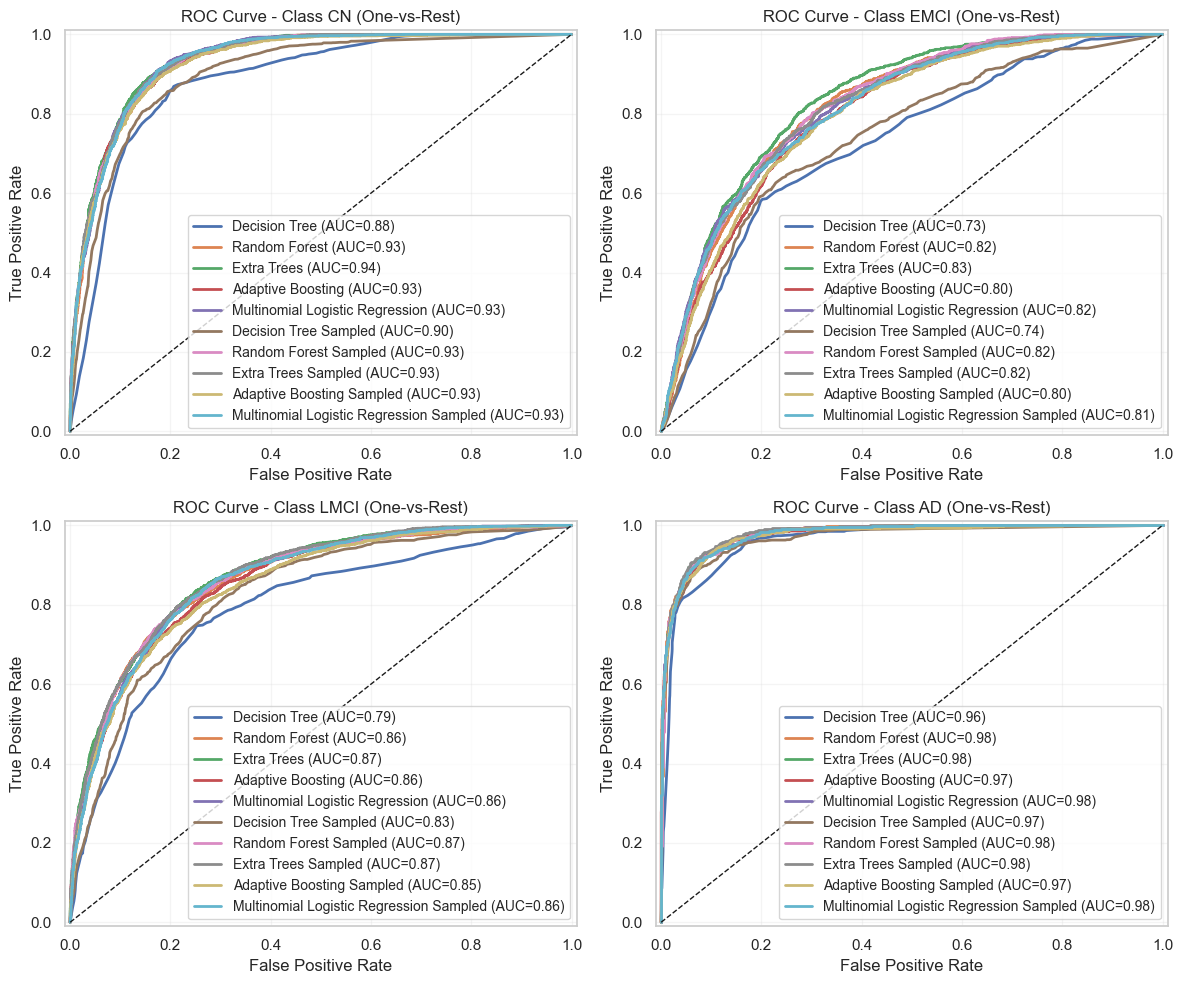

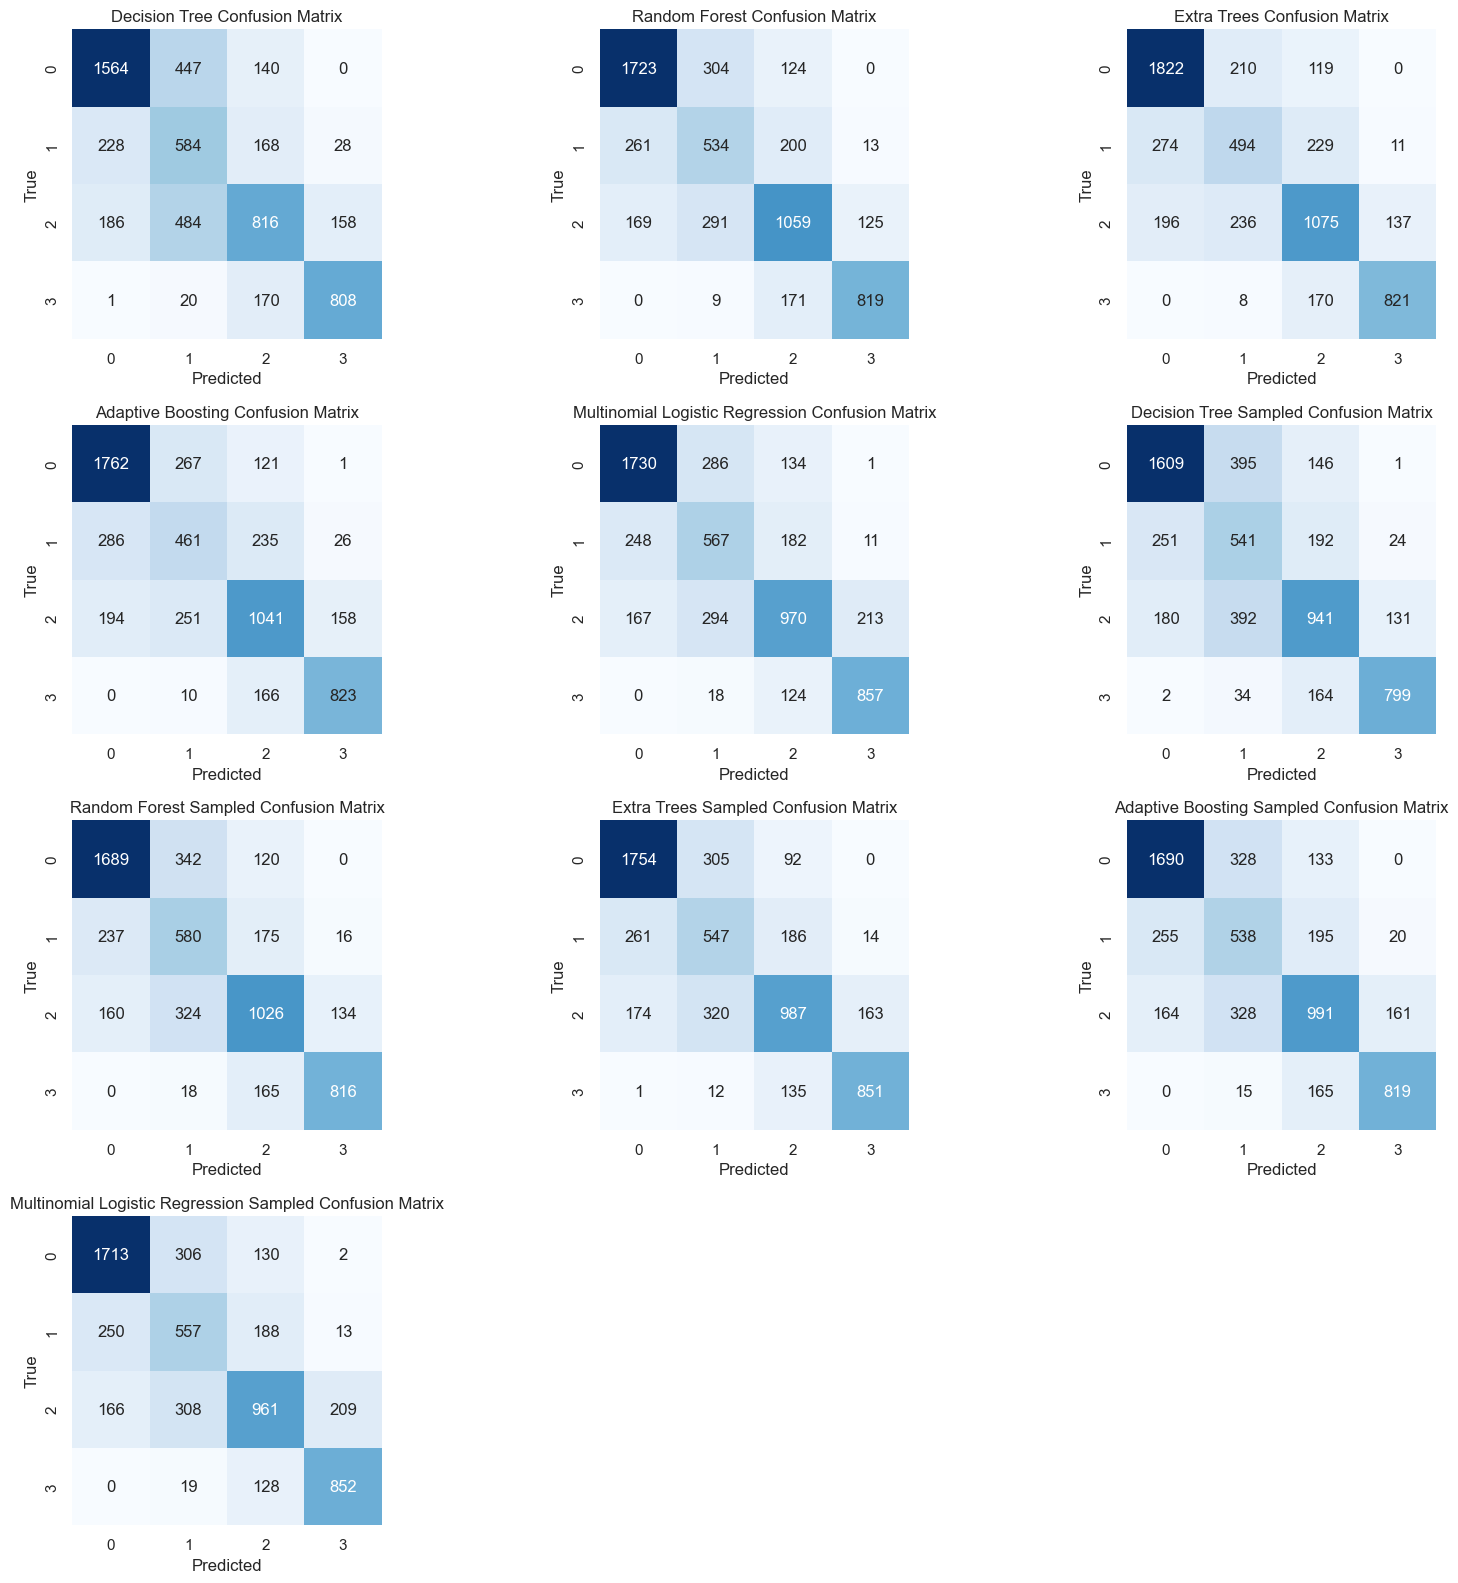

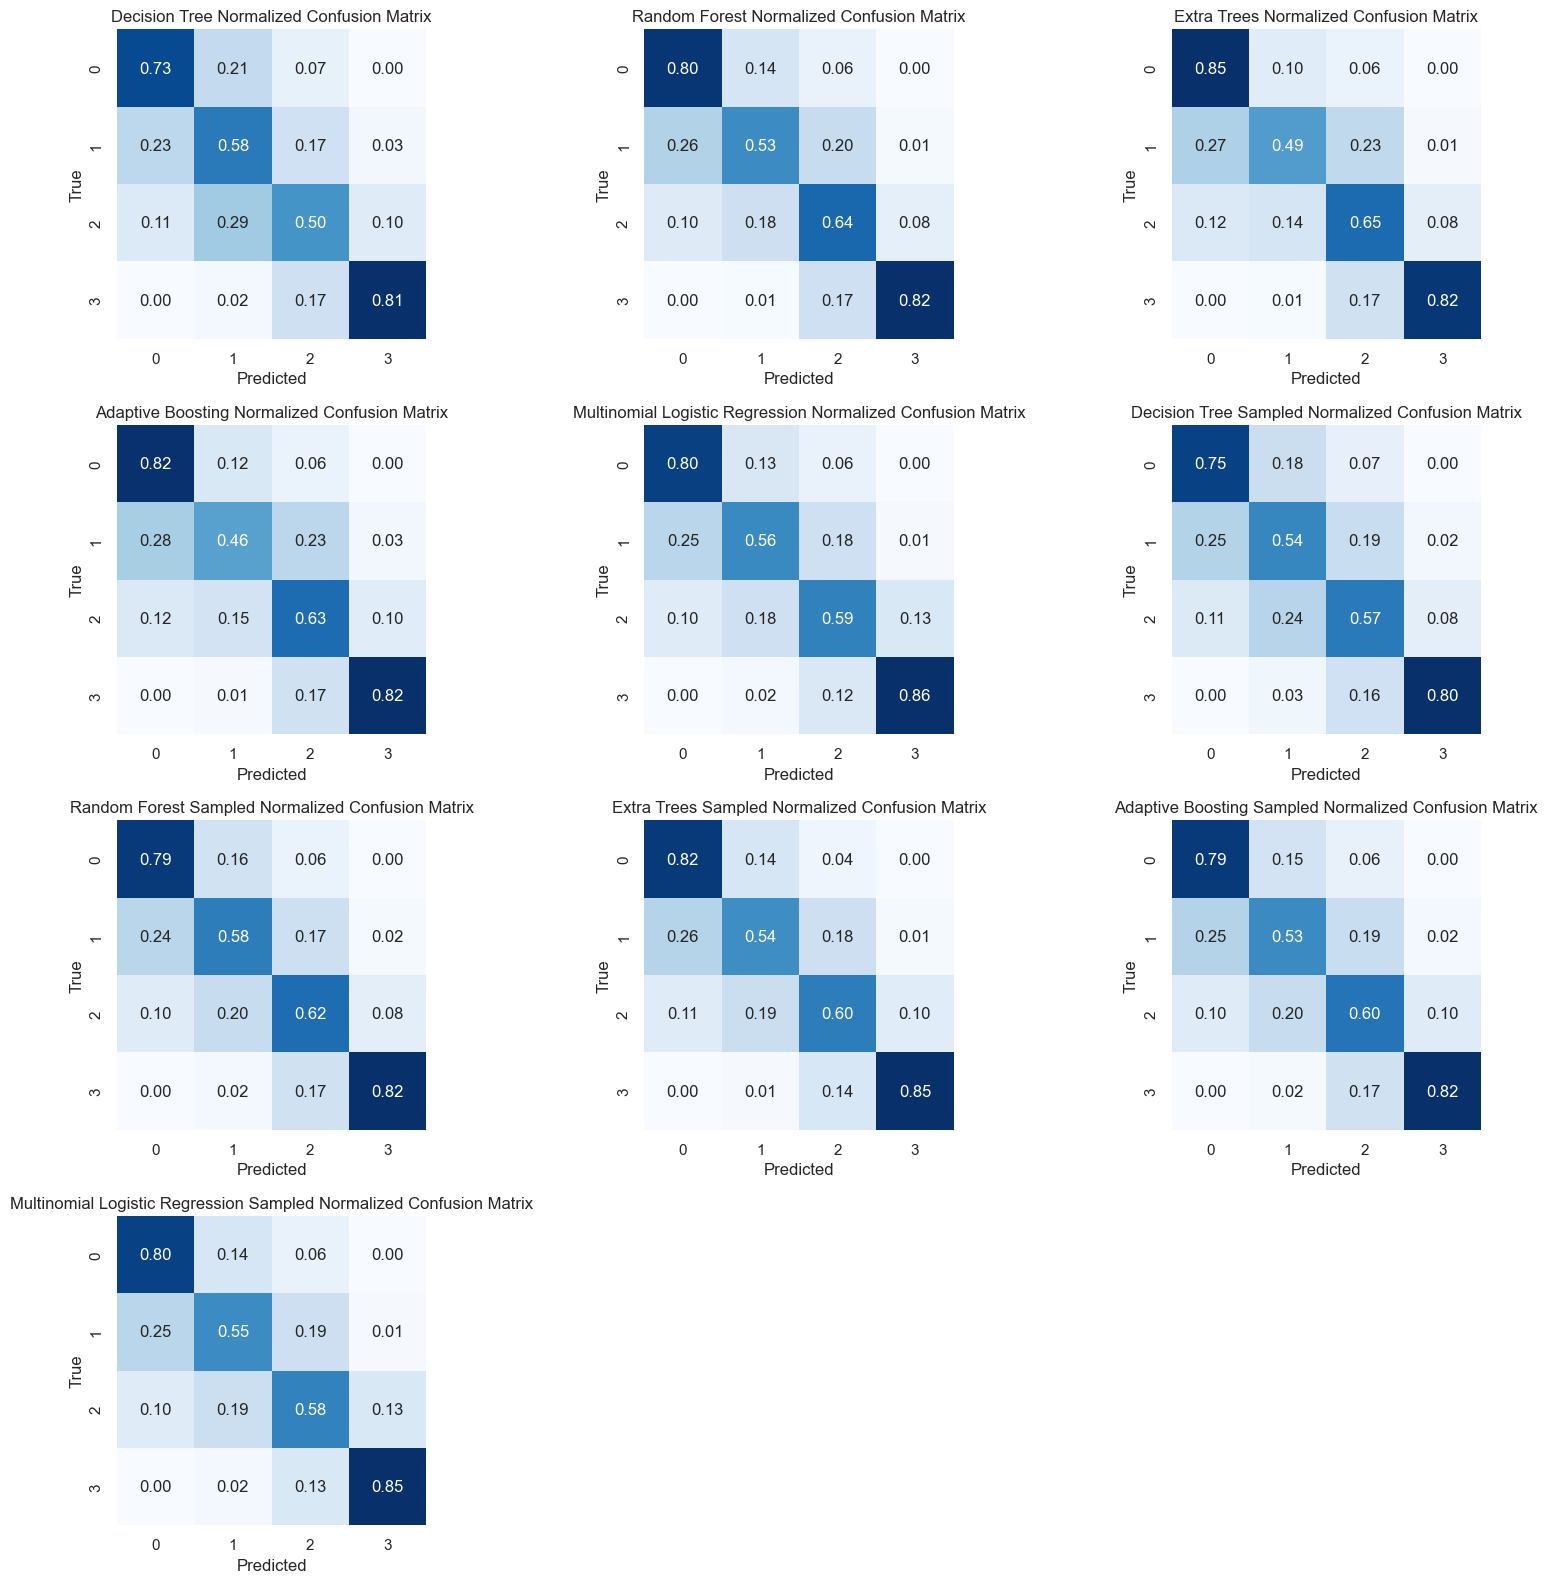

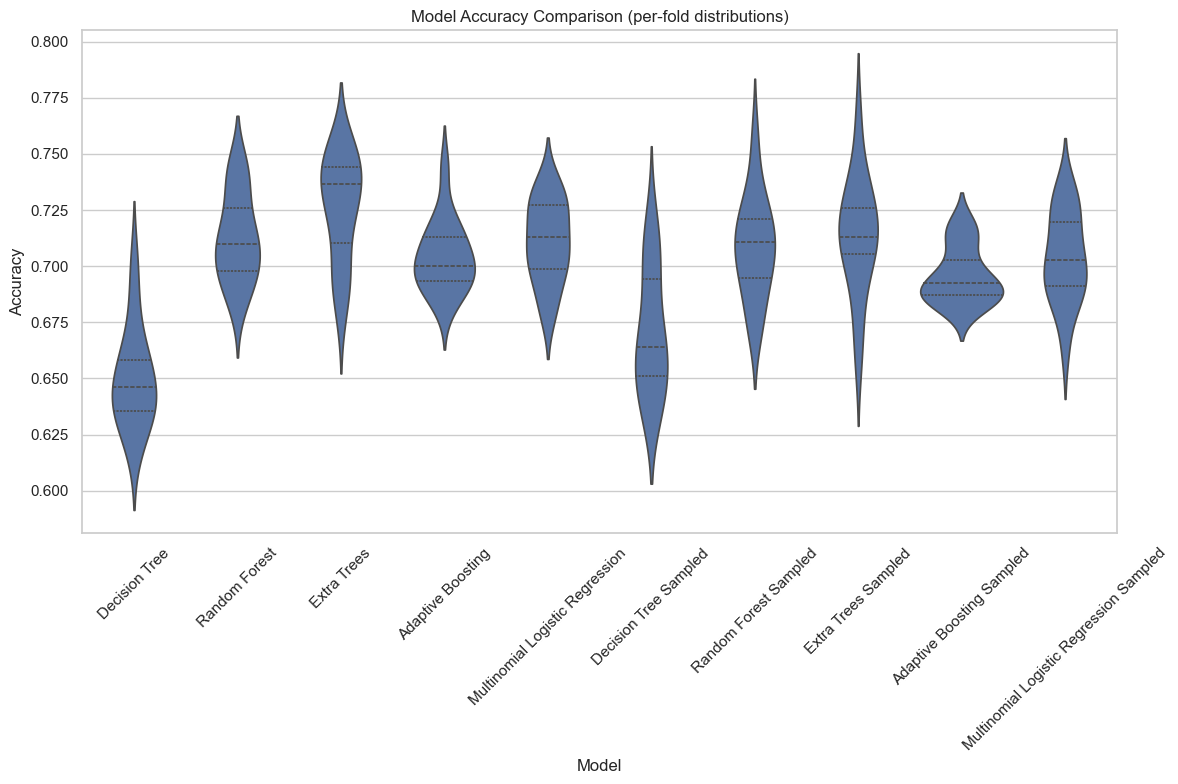

Model A                                  Model B  \
0                 Adaptive Boosting                    Random Forest Sampled   
1             Random Forest Sampled                      Extra Trees Sampled   
2   Multinomial Logistic Regression                    Random Forest Sampled   
3                       Extra Trees                    Random Forest Sampled   
4             Random Forest Sampled  Multinomial Logistic Regression Sampled   
5             Decision Tree Sampled                    Random Forest Sampled   
6                       Extra Trees          Multinomial Logistic Regression   
7                     Random Forest                    Random Forest Sampled   
8                 Adaptive Boosting                Adaptive Boosting Sampled   
9                 Adaptive Boosting                    Decision Tree Sampled   
10                    Decision Tree          Multinomial Logistic Regression   
11                    Random Forest                        Adaptive Boosting   
12                    Decision Tree                        Adaptive Boosting   
13                      Extra Trees                        Adaptive Boosting   
14                    Decision Tree  Multinomial Logistic Regression Sampled   
15                    Random Forest                Adaptive Boosting Sampled   
16  Multinomial Logistic Regression                Adaptive Boosting Sampled   
17  Multinomial Logistic Regression                    Decision Tree Sampled   
18  Multinomial Logistic Regression                      Extra Trees Sampled   
19  Multinomial Logistic Regression  Multinomial Logistic Regression Sampled   
20                Adaptive Boosting                      Extra Trees Sampled   
21                    Random Forest          Multinomial Logistic Regression   
22                      Extra Trees  Multinomial Logistic Regression Sampled   
23                    Decision Tree                    Random Forest Sampled   
24        Adaptive Boosting Sampled  Multinomial Logistic Regression Sampled   
25              Extra Trees Sampled                Adaptive Boosting Sampled   
26            Random Forest Sampled                Adaptive Boosting Sampled   
27                    Decision Tree                      Extra Trees Sampled   
28                    Decision Tree                              Extra Trees   
29                      Extra Trees                Adaptive Boosting Sampled   
30                    Random Forest                    Decision Tree Sampled   
31            Decision Tree Sampled  Multinomial Logistic Regression Sampled   
32                    Decision Tree                    Decision Tree Sampled   
33                    Decision Tree                            Random Forest   
34            Decision Tree Sampled                Adaptive Boosting Sampled   
35              Extra Trees Sampled  Multinomial Logistic Regression Sampled   
36                    Random Forest  Multinomial Logistic Regression Sampled   
37                Adaptive Boosting          Multinomial Logistic Regression   
38            Decision Tree Sampled                      Extra Trees Sampled   
39                      Extra Trees                      Extra Trees Sampled   
40                Adaptive Boosting  Multinomial Logistic Regression Sampled   
41                    Random Forest                              Extra Trees   
42                    Random Forest                      Extra Trees Sampled   
43                      Extra Trees                    Decision Tree Sampled   
44                    Decision Tree                Adaptive Boosting Sampled   

    Statistic   P-value  
0        12.0  0.004272  
1        13.0  0.005371  
2        14.0  0.006714  
3        21.0  0.025574  
4        21.0  0.025574  
5        24.0  0.041260  
6        24.0  0.041260  
7        25.0  0.047913  
8        29.0  0.083252  
9        29.0  0.083252  
10       30.0  0.094604  
11       31.0  0.106995  
12       

In [16]:
classifier = ADNIClassifier(classifier="Alternative")
res = classifier.fit_evaluate_store_models(X_train, y_train, output_dir="../results/all_models/alternative")
result_df = res["results_df"]
per_class_df = res["per_class_df"]
wilcoxon_results_df = res["wilcoxon_results_df"]

### Save Trees and Rules of Decision Trees

In [17]:
save_xai_models(X_train=train.drop(columns=['DX']), models_dir="../results/all_models/alternative")

Found 2 Decision_Tree models: ['Decision_Tree', 'Decision_Tree_Sampled']
XAI outputs saved.


### Final Results

In [18]:
display(result_df)
display(wilcoxon_results_df)

Model  F1 Score (macro)  Accuracy  \
2                              Extra Trees          0.705956  0.725957   
1                            Random Forest          0.699508  0.712685   
7                      Extra Trees Sampled          0.698837  0.713375   
6                    Random Forest Sampled          0.698488  0.708549   
4          Multinomial Logistic Regression          0.696534  0.710789   
9  Multinomial Logistic Regression Sampled          0.689613  0.703723   
3                        Adaptive Boosting          0.683303  0.704412   
8                Adaptive Boosting Sampled          0.682952  0.695967   
5                    Decision Tree Sampled          0.662868  0.670458   
0                            Decision Tree          0.645751  0.650121   

   Balanced Accuracy  Precision (weighted)  Recall (weighted)  \
2           0.703211              0.722339           0.725957   
1           0.698691              0.718661           0.712685   
7           0.702578              0.719488           0.713375   
6           0.700379              0.720980           0.708549   
4           0.703665              0.714868           0.710789   
9           0.696589              0.709482           0.703723   
3           0.683383              0.701644           0.704412   
8           0.685507              0.704626           0.695967   
5           0.664229              0.689962           0.670458   
0           0.652907              0.677733           0.650121   

   F1 Score (weighted)  ROC AUC (macro)  
2             0.723679         0.905522  
1             0.715140         0.897799  
7             0.714626         0.901032  
6             0.713039         0.899470  
4             0.711064         0.898761  
9             0.704708         0.896488  
3             0.702773         0.890973  
8             0.699098         0.887699  
5             0.677401         0.858902  
0             0.657591         0.840910

Model A                                  Model B  \
0                 Adaptive Boosting                    Random Forest Sampled   
1             Random Forest Sampled                      Extra Trees Sampled   
2   Multinomial Logistic Regression                    Random Forest Sampled   
3                       Extra Trees                    Random Forest Sampled   
4             Random Forest Sampled  Multinomial Logistic Regression Sampled   
5             Decision Tree Sampled                    Random Forest Sampled   
6                       Extra Trees          Multinomial Logistic Regression   
7                     Random Forest                    Random Forest Sampled   
8                 Adaptive Boosting                Adaptive Boosting Sampled   
9                 Adaptive Boosting                    Decision Tree Sampled   
10                    Decision Tree          Multinomial Logistic Regression   
11                    Random Forest                        Adaptive Boosting   
12                    Decision Tree                        Adaptive Boosting   
13                      Extra Trees                        Adaptive Boosting   
14                    Decision Tree  Multinomial Logistic Regression Sampled   
15                    Random Forest                Adaptive Boosting Sampled   
16  Multinomial Logistic Regression                Adaptive Boosting Sampled   
17  Multinomial Logistic Regression                    Decision Tree Sampled   
18  Multinomial Logistic Regression                      Extra Trees Sampled   
19  Multinomial Logistic Regression  Multinomial Logistic Regression Sampled   
20                Adaptive Boosting                      Extra Trees Sampled   
21                    Random Forest          Multinomial Logistic Regression   
22                      Extra Trees  Multinomial Logistic Regression Sampled   
23                    Decision Tree                    Random Forest Sampled   
24        Adaptive Boosting Sampled  Multinomial Logistic Regression Sampled   
25              Extra Trees Sampled                Adaptive Boosting Sampled   
26            Random Forest Sampled                Adaptive Boosting Sampled   
27                    Decision Tree                      Extra Trees Sampled   
28                    Decision Tree                              Extra Trees   
29                      Extra Trees                Adaptive Boosting Sampled   
30                    Random Forest                    Decision Tree Sampled   
31            Decision Tree Sampled  Multinomial Logistic Regression Sampled   
32                    Decision Tree                    Decision Tree Sampled   
33                    Decision Tree                            Random Forest   
34            Decision Tree Sampled                Adaptive Boosting Sampled   
35              Extra Trees Sampled  Multinomial Logistic Regression Sampled   
36                    Random Forest  Multinomial Logistic Regression Sampled   
37                Adaptive Boosting          Multinomial Logistic Regression   
38            Decision Tree Sampled                      Extra Trees Sampled   
39                      Extra Trees                      Extra Trees Sampled   
40                Adaptive Boosting  Multinomial Logistic Regression Sampled   
41                    Random Forest                              Extra Trees   
42                    Random Forest                      Extra Trees Sampled   
43                      Extra Trees                    Decision Tree Sampled   
44                    Decision Tree                Adaptive Boosting Sampled   

    Statistic   P-value  
0        12.0  0.004272  
1        13.0  0.005371  
2        14.0  0.006714  
3        21.0  0.025574  
4        21.0  0.025574  
5        24.0  0.041260  
6        24.0  0.041260  
7        25.0  0.047913  
8        29.0  0.083252  
9        29.0  0.083252  
10       30.0  0.094604  
11       31.0  0.106995  
12       

As expected, removing `CDRSB`, `LDELTOTAL`, and `mPACCdigit` dramatically reduced performance. Especially in the prediction of the Mild Cognitive Empairment classes (**ECMI** and **LMCI**).

The second best model is Extra Trees with **F1 Score (Macro)** of 0.7060, **Accuracy** of 0.7260, and **ROC AUC (macro)** of 0.9055. The **sampled** models perform very similarly to the non-sampled versions, but generally slightly worse or on par (very small differences, tenths of a point). Models based on **Logistic Regression** follow closely behind, while **Decision Tree** and its **sampled variant** show the **weakest performance**, with significantly lower values ​​in both macro F1 and ROC AUC. 

Analysis of the **Wilcoxon test** suggests that some differences between pairs of models are statistically significant, particularly those involving **Sampled Random Forest** compared to weaker models such as **Adaptive Boosting** or **Sampled Decision Tree**, or to slightly better models such as **Extra Trees** and **Sampled Extra Trees**. However, practical interpretation of these results is limited by the fact that many differences, while statistically significant, are extremely small in absolute terms. 

Overall, the joint evaluation of the metrics and statistical tests leads to the conclusion that we cannot establish with certainty whether one model is better than another, but of all of them **Extra Trees** is the most convincing model.


## Explainability

In [19]:
train = pd.read_csv("../data/train.csv")
train.drop(columns=["CDRSB", "LDELTOTAL", "mPACCdigit"], inplace=True)

# Target column
y_train = train['DX']

# All other columns as features
X_train = train.drop(columns=['DX'])

display(train)

DX  AGE  PTGENDER  PTEDUCAT  APOE4  MMSE  ADAS13  FAQ  MOCA  TRABSCOR  \
0       AD   80         1        14      0    21      42   19    13       300   
1     LMCI   82         1        20      0    24      20    4    20       155   
2     LMCI   71         1        19      0    26       8    2    25       106   
3       CN   75         0        20      0    30       6    0    26        58   
4       CN   81         0        19      0    29       8    0    29        54   
...    ...  ...       ...       ...    ...   ...     ...  ...   ...       ...   
1929  LMCI   64         0        14      2    27      22    9    22        62   
1930  LMCI   82         1        18      0    28      23    1    25        79   
1931  LMCI   76         1        12      0    25      16    1    22       300   
1932  LMCI   74         1        19      1    26      27    8    21       102   
1933  EMCI   72         1        14      1    26      15    1    24       116   

      RAVLT_immediate  RAVLT_learning  RAVLT_perc_forgetting  EcogPtMem  \
0                  15               1               100.0000    3.14286   
1                  29               0                83.3333    2.10000   
2                  51               2               -18.1818    2.75000   
3                  61               7                20.0000    1.75000   
4                  54               7                28.5714    1.87500   
...               ...             ...                    ...        ...   
1929               31               1               100.0000    2.97500   
1930               33               1                42.8571    2.12500   
1931               27               2                16.6667    1.60000   
1932               32               1               100.0000    1.87500   
1933               25               0                25.0000    2.12500   

      EcogPtLang  EcogPtVisspat  EcogPtPlan  EcogPtOrgan  EcogPtDivatt  \
0       3.000000       3.000000    3.200000     2.500000          2.75   
1       1.780554       1.274284    1.373334     1.699998          1.65   
2       2.555560       2.285710    3.200000     3.833330          3.50   
3       1.333330       1.000000    1.000000     1.166670          1.00   
4       1.555560       1.000000    1.000000     1.333330          1.75   
...          ...            ...         ...          ...           ...   
1929    1.930556       1.585714    1.400000     1.416668          1.95   
1930    1.125000       1.166670    2.000000     2.500000          2.00   
1931    1.533332       1.219048    1.040000     1.133334          1.45   
1932    1.333330       1.000000    1.200000     1.333330          1.00   
1933    1.666670       1.000000    1.000000     1.166670          2.00   

      EcogSPMem  EcogSPLang  EcogSPVisspat  EcogSPPlan  EcogSPOrgan  \
0      4.000000    3.444440       2.666670    3.000000     3.666670   
1      2.950000    2.530556       2.014286    1.756666     2.316666   
2      1.510714    1.266666       1.438096    1.760000     1.680000   
3      1.000000    1.000000       1.000000    1.000000     1.000000   
4      1.375000    1.111110       1.000000    1.200000     1.166670   
...         ...         ...            ...         ...          ...   
1929   3.025000    1.955554       1.671428    1.600000     1.866666   
1930   2.625000    1.625000       1.166670    1.400000     1.833330   
1931   2.100000    1.322222       1.657144    1.400000     1.366666   
1932   3.125000    2.875000       1.857140    1.333330     2.250000   
1933   1.750000    1.714290       1.200000    1.250000     1.000000   

      EcogSPDivatt       FDG  TAU/ABETA  PTAU/ABETA  Hippocampus/ICV  \
0             3.75  1.042620   0.630939    0.061115         0.003517   
1             2.75  1.080580   0.421770    0.041719         0.003360   
2             1.85  1.414550   0.182691    0.016757         0.005090   
3             1.00  1.118820   0.263255    0.024724         0.004908   
4             1.75  1.270141   0

Loaded model: Adaptive_Boosting
Loaded model: Adaptive_Boosting_Sampled
Loaded model: Decision_Tree
Loaded model: Decision_Tree_Sampled
Loaded model: Extra_Trees
Loaded model: Extra_Trees_Sampled
Loaded model: Multinomial_Logistic_Regression
Loaded model: Multinomial_Logistic_Regression_Sampled
Loaded model: Random_Forest
Loaded model: Random_Forest_Sampled


PermutationExplainer explainer: 1935it [45:09,  1.40s/it]                           


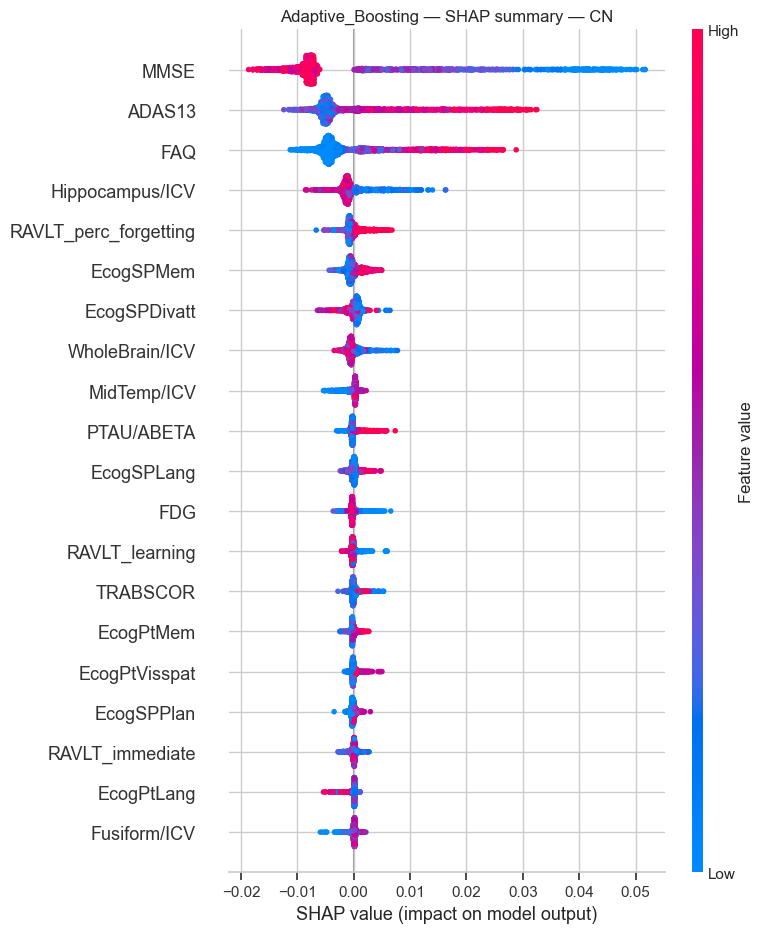

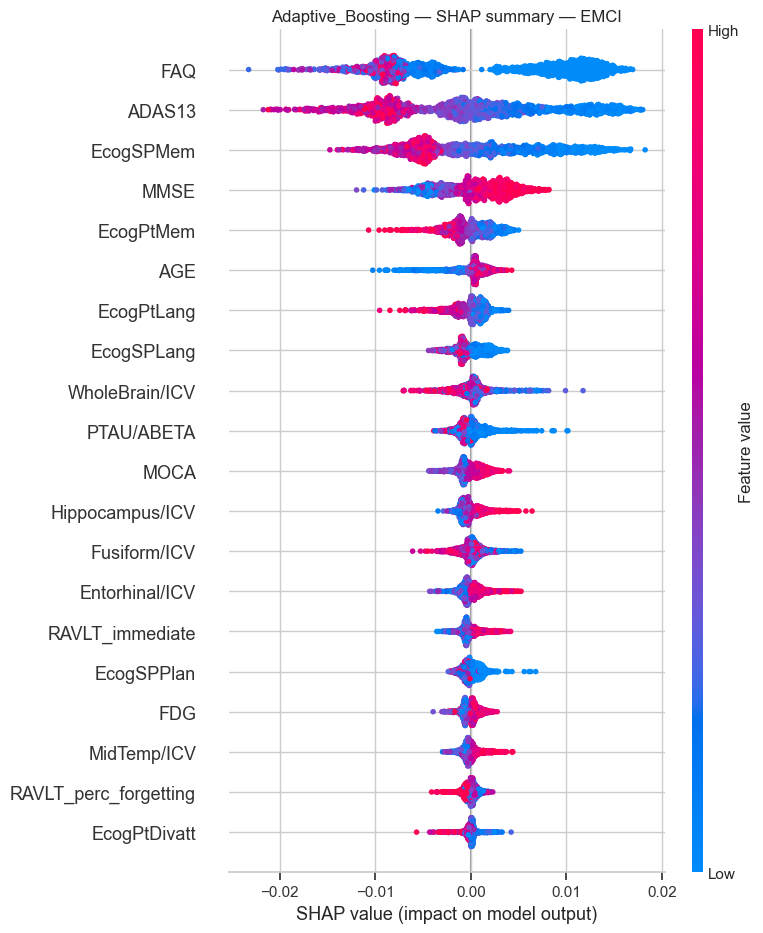

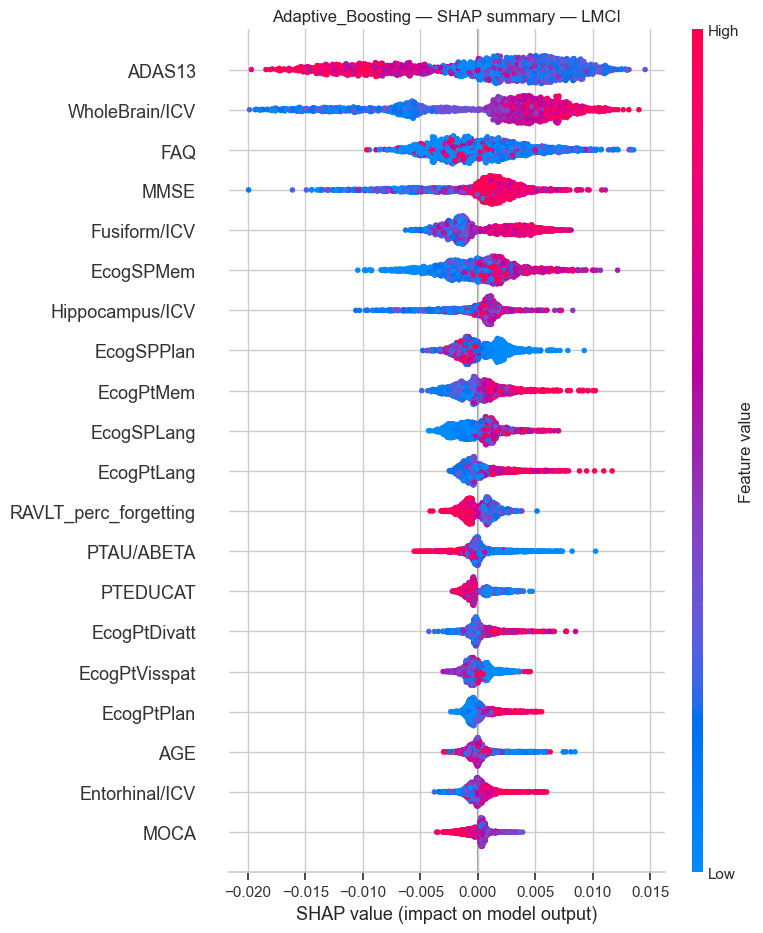

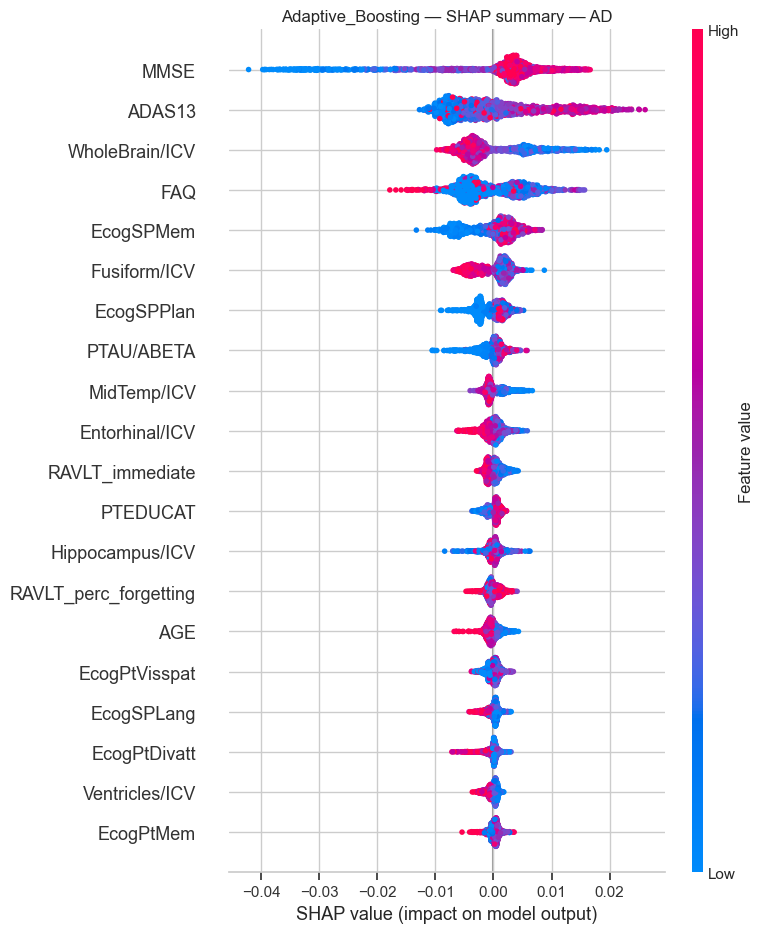

PermutationExplainer explainer: 1935it [19:03,  1.67it/s]                          


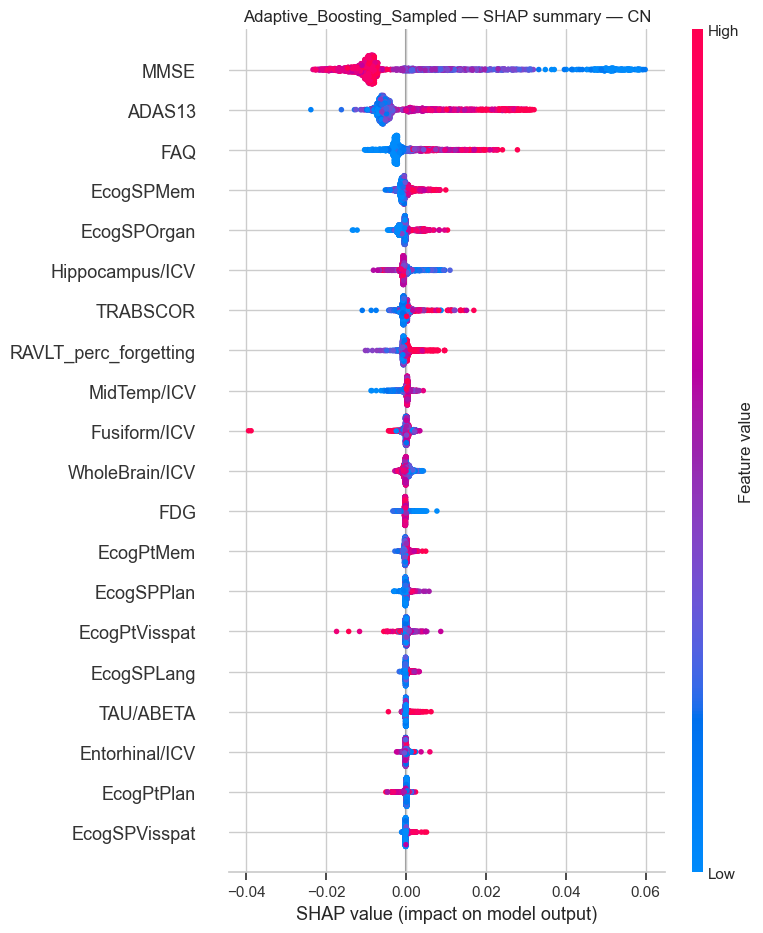

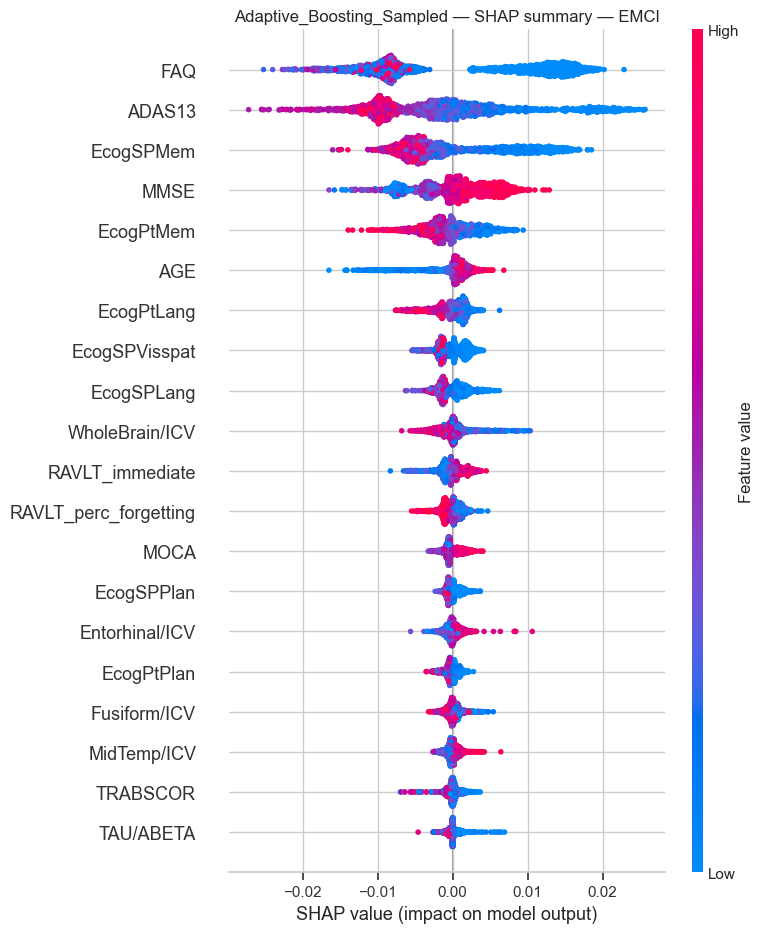

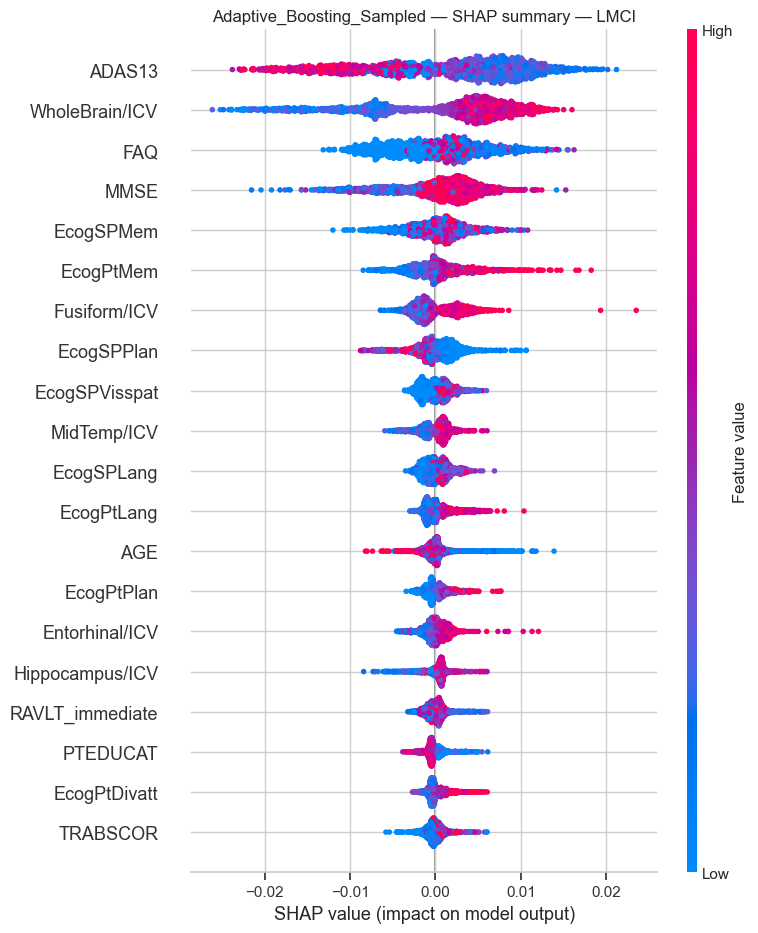

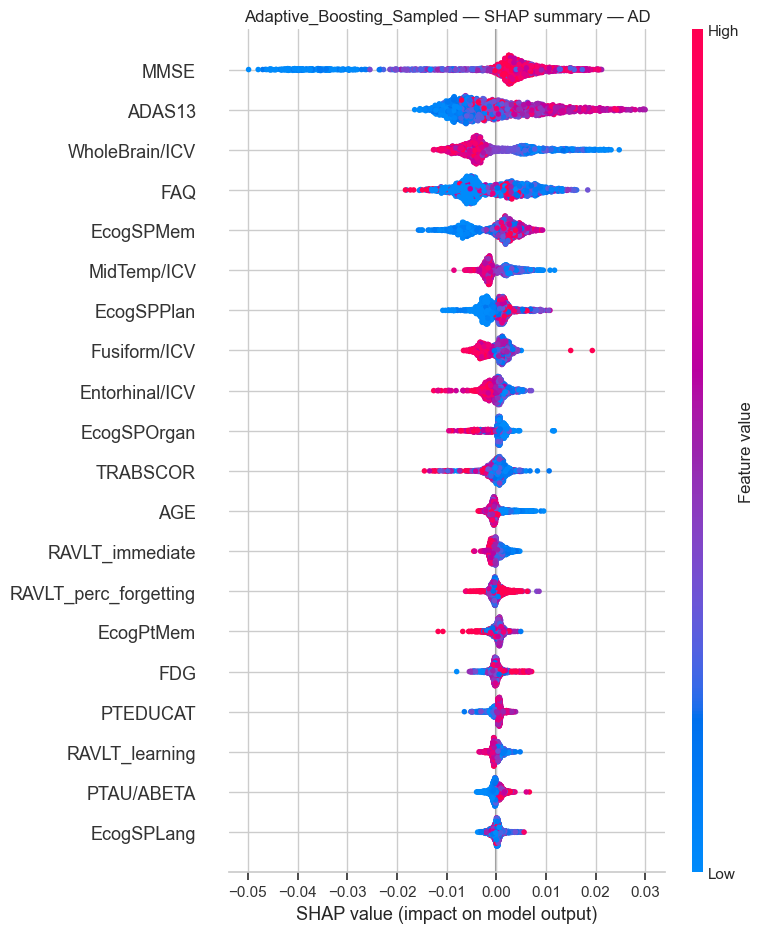

PermutationExplainer explainer: 1935it [01:00, 27.22it/s]                          


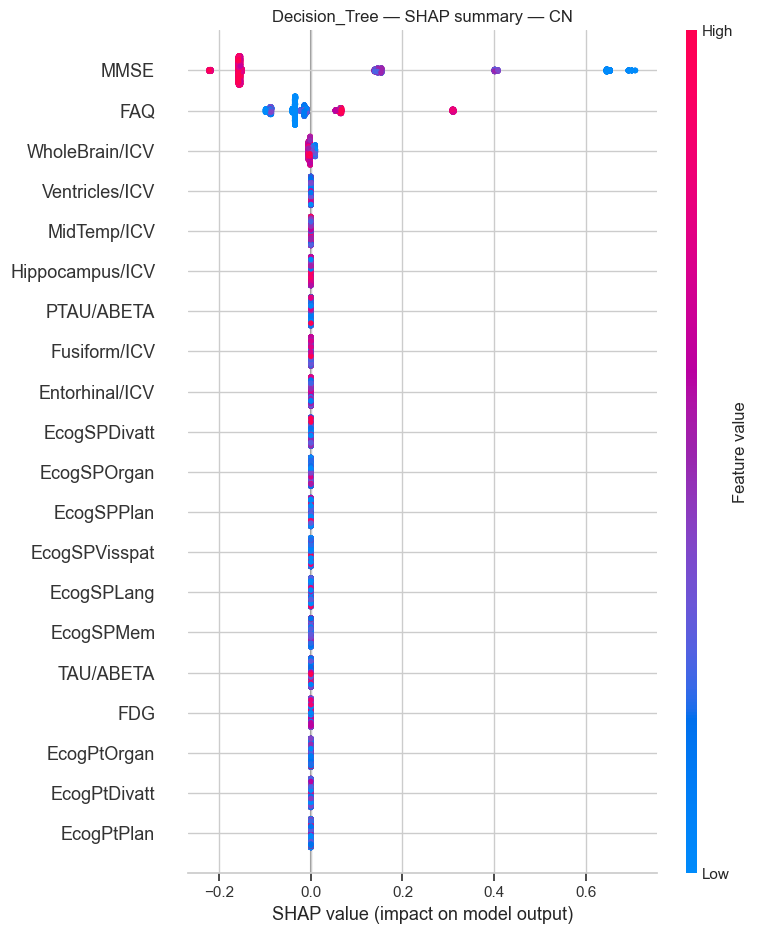

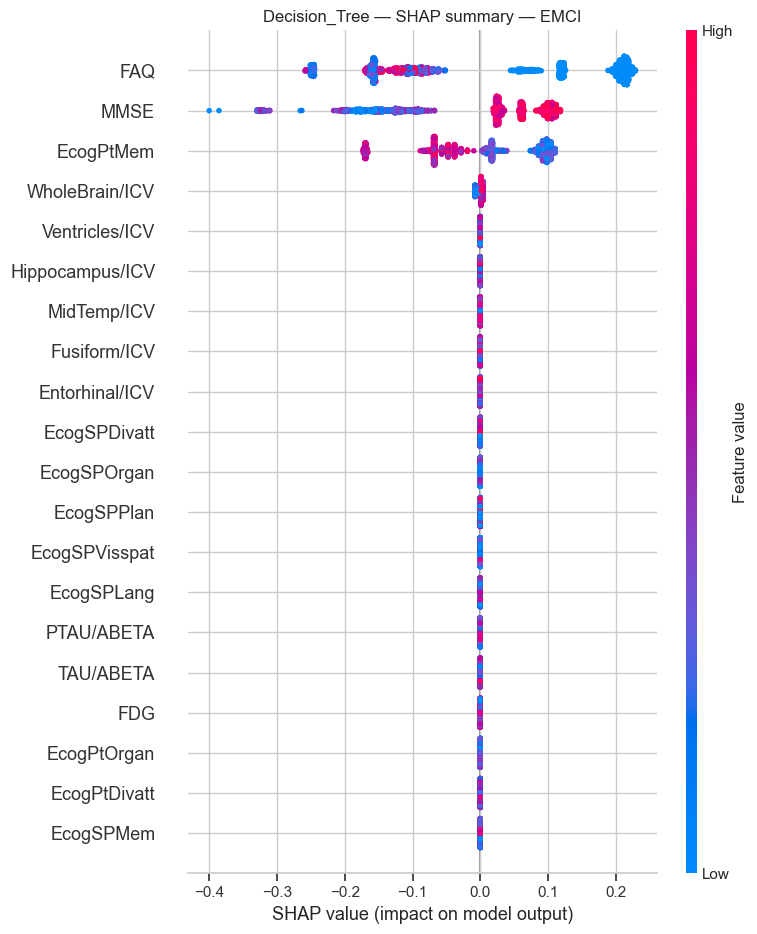

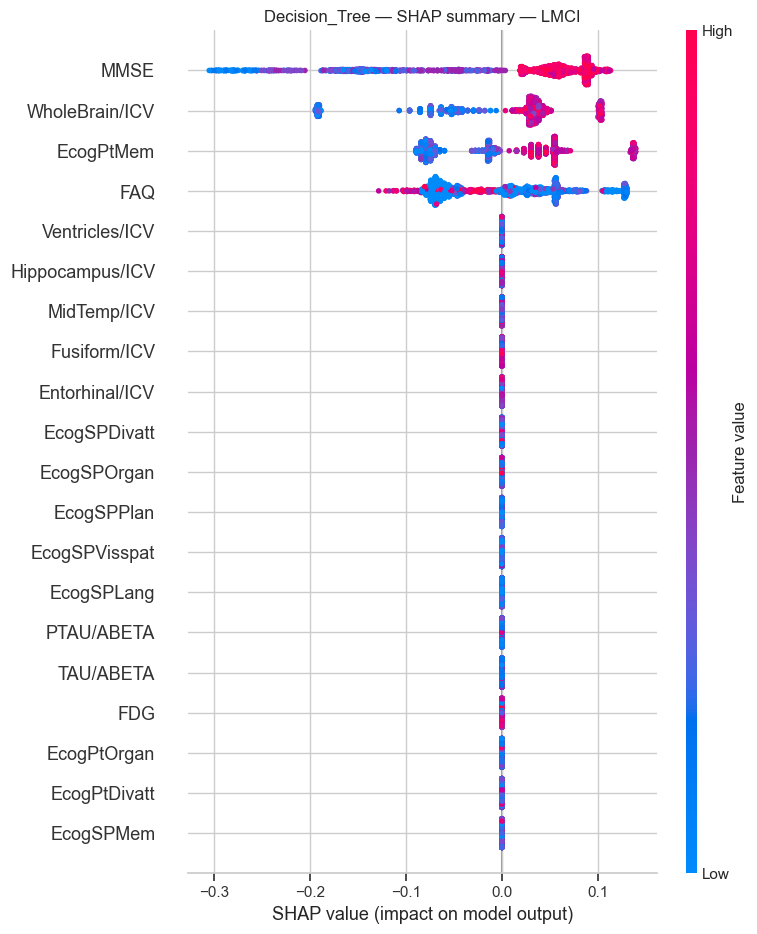

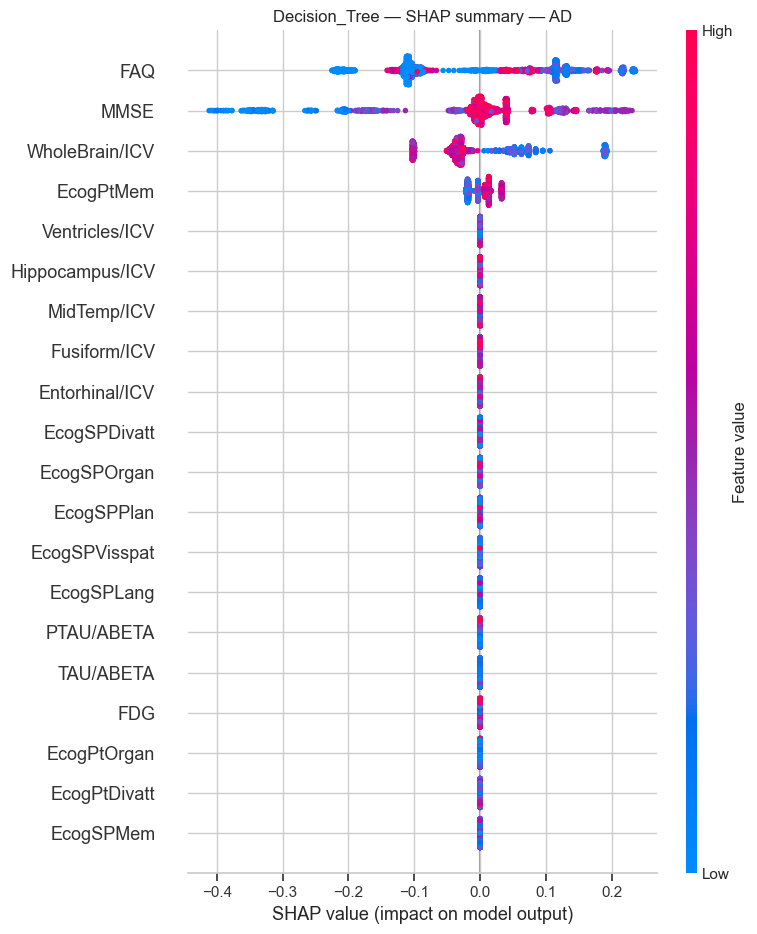

PermutationExplainer explainer: 1935it [01:00, 26.59it/s]                          


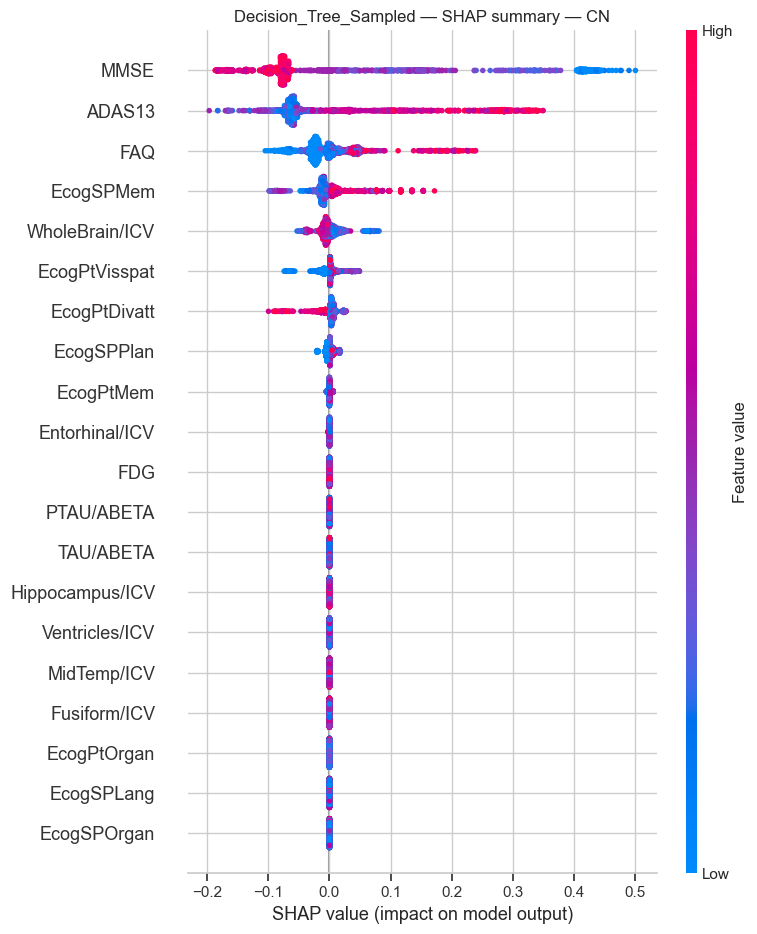

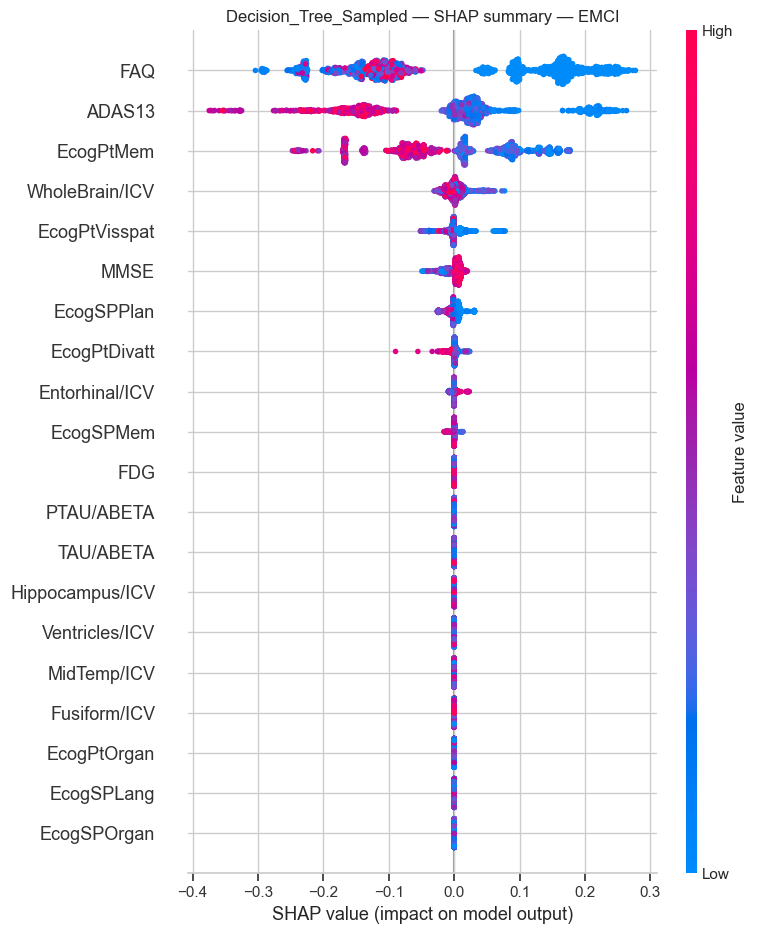

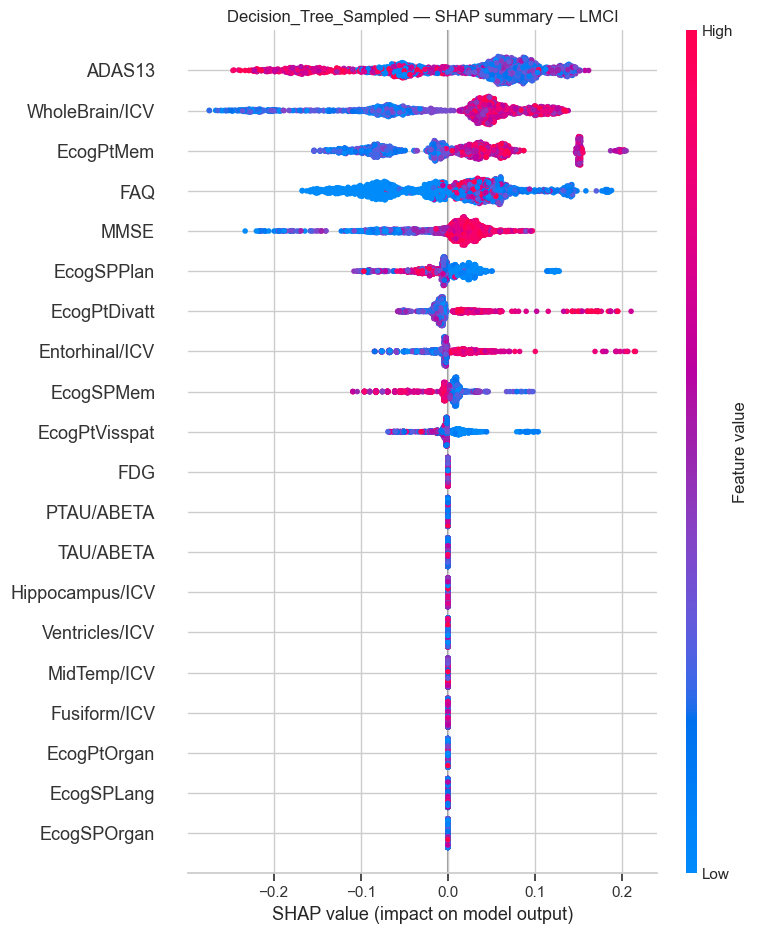

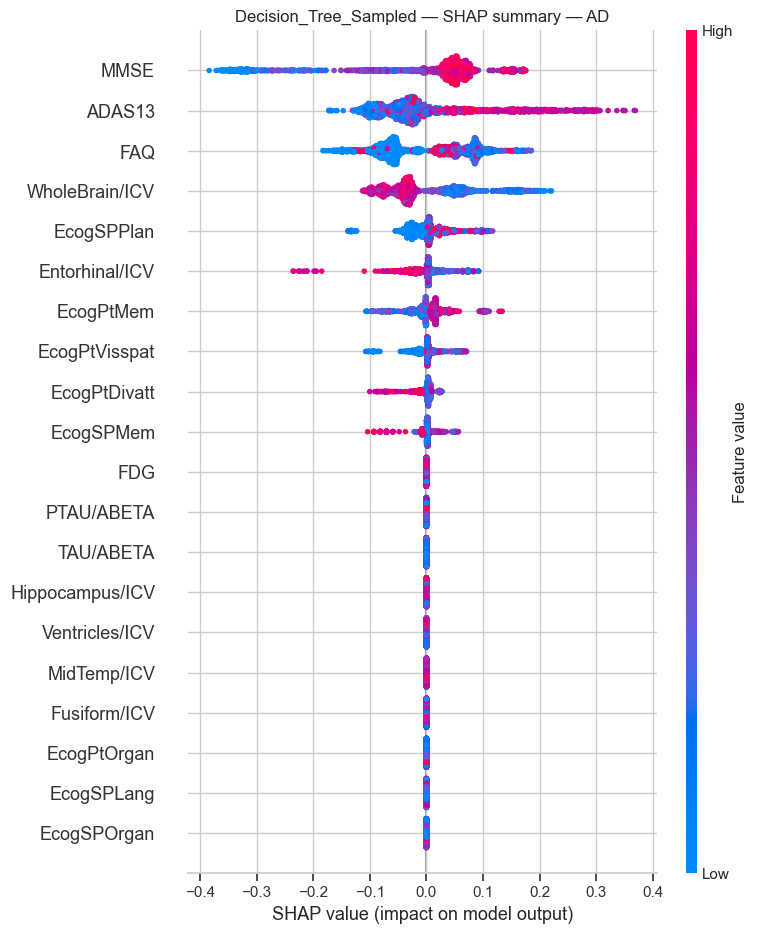

PermutationExplainer explainer: 1935it [15:05,  2.11it/s]                          


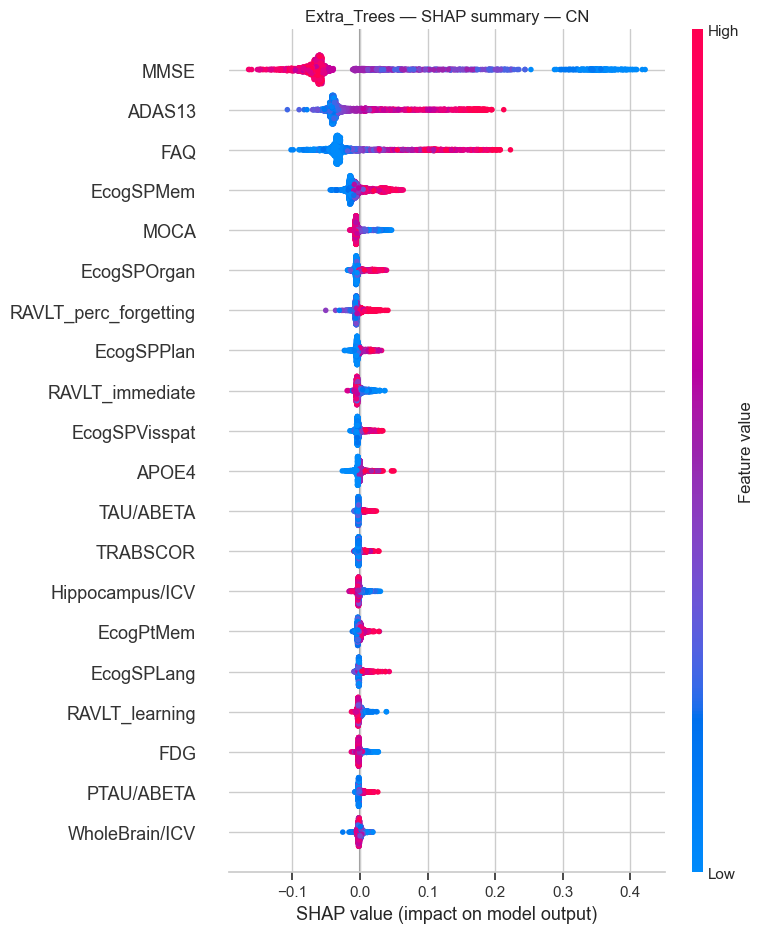

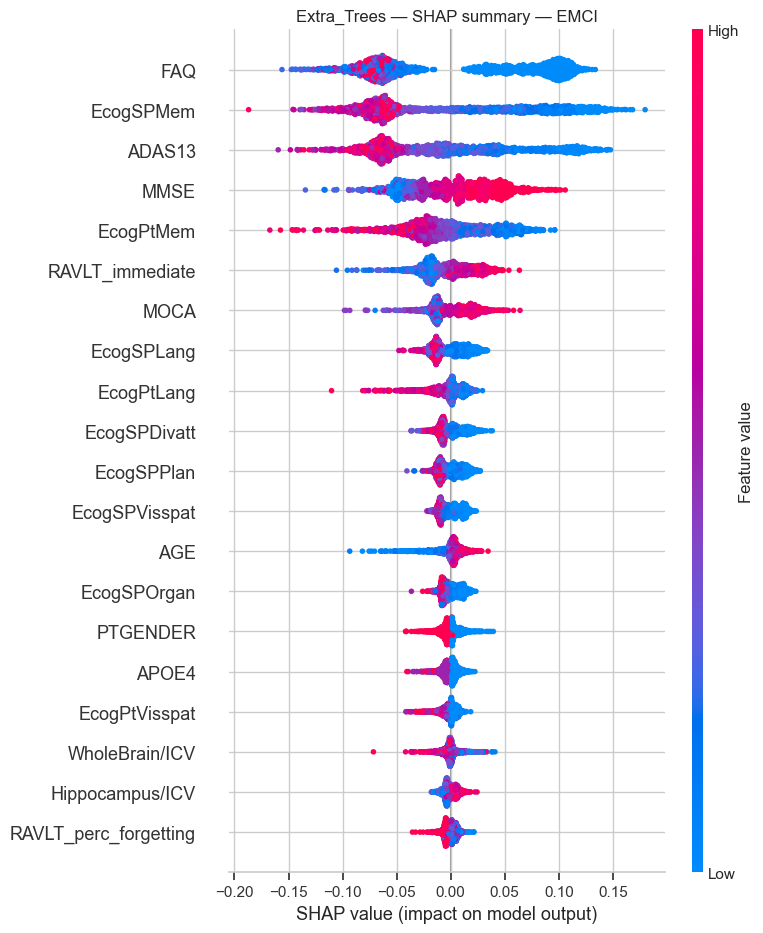

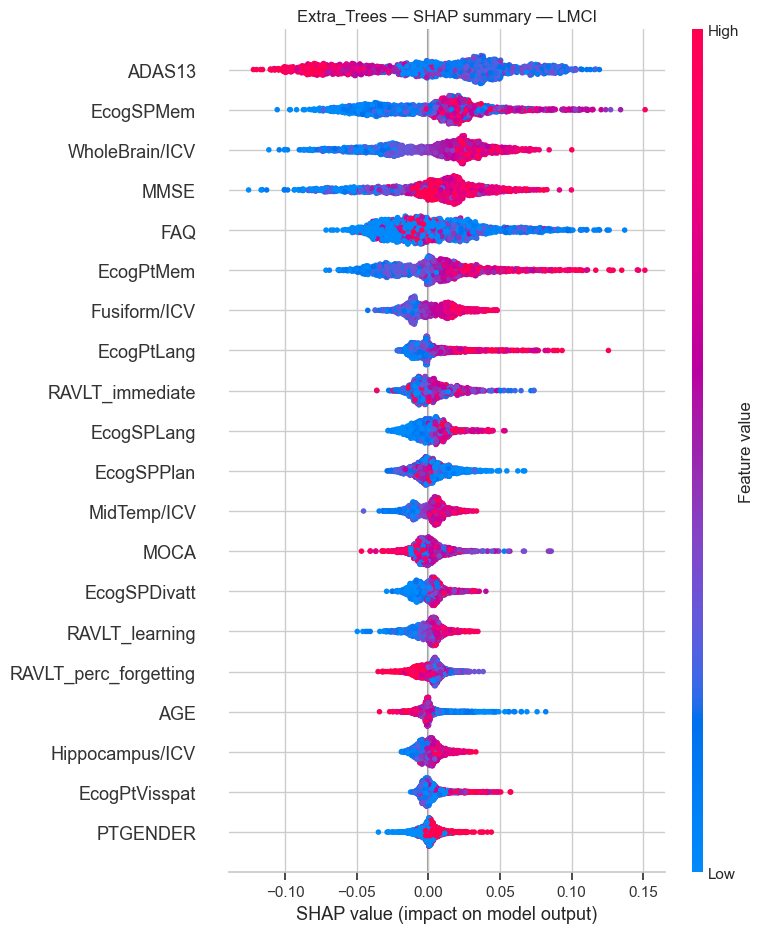

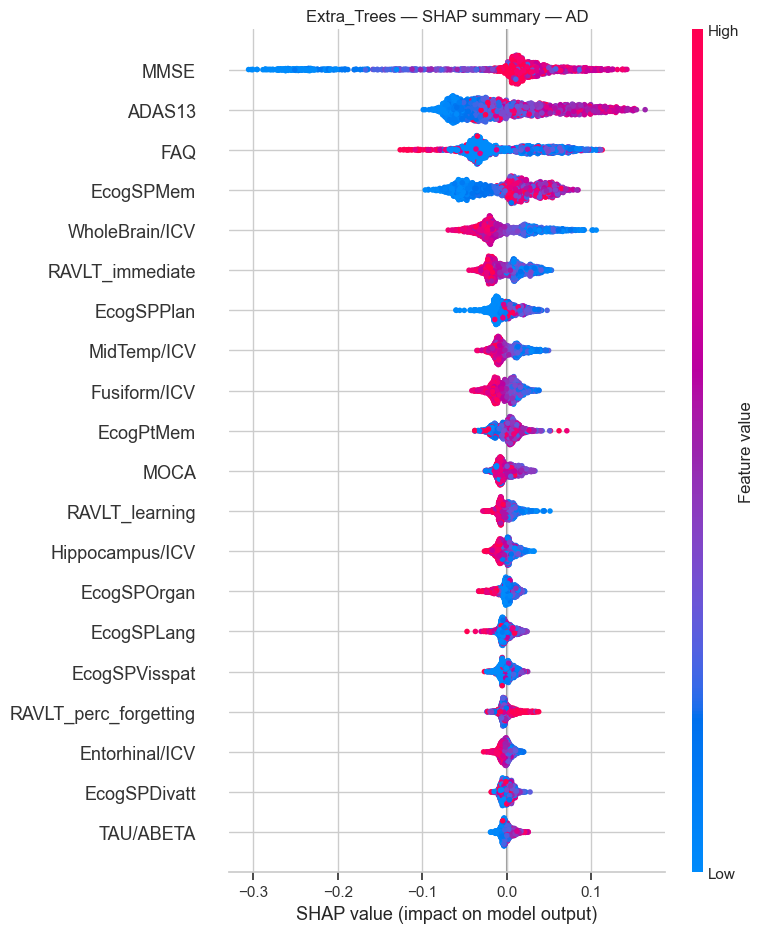

PermutationExplainer explainer: 1935it [14:33,  2.19it/s]                          


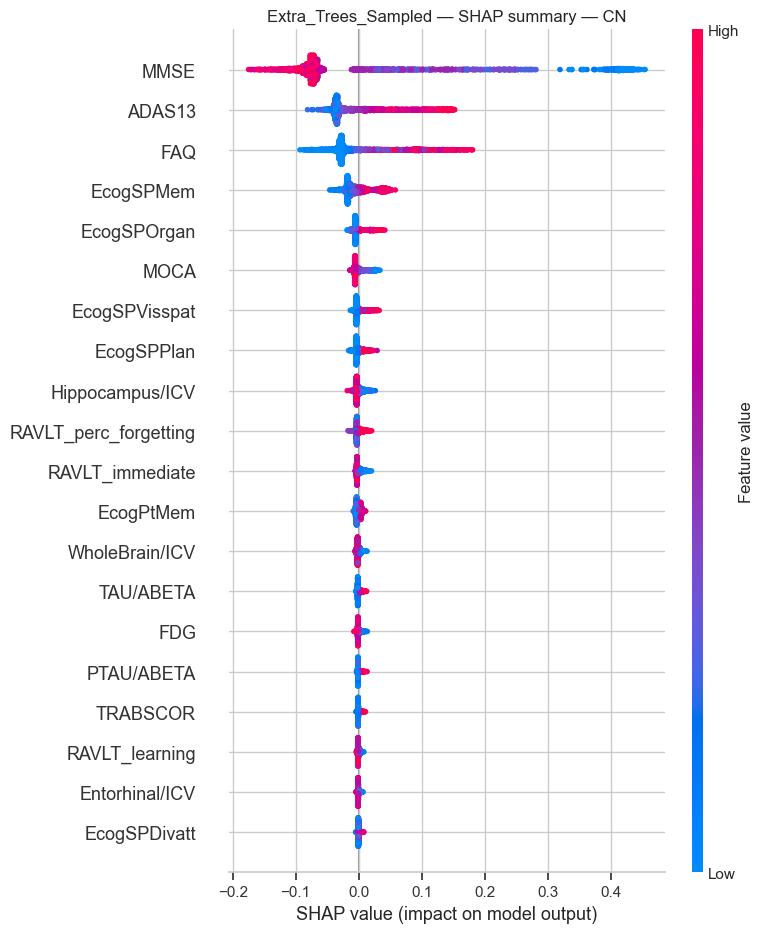

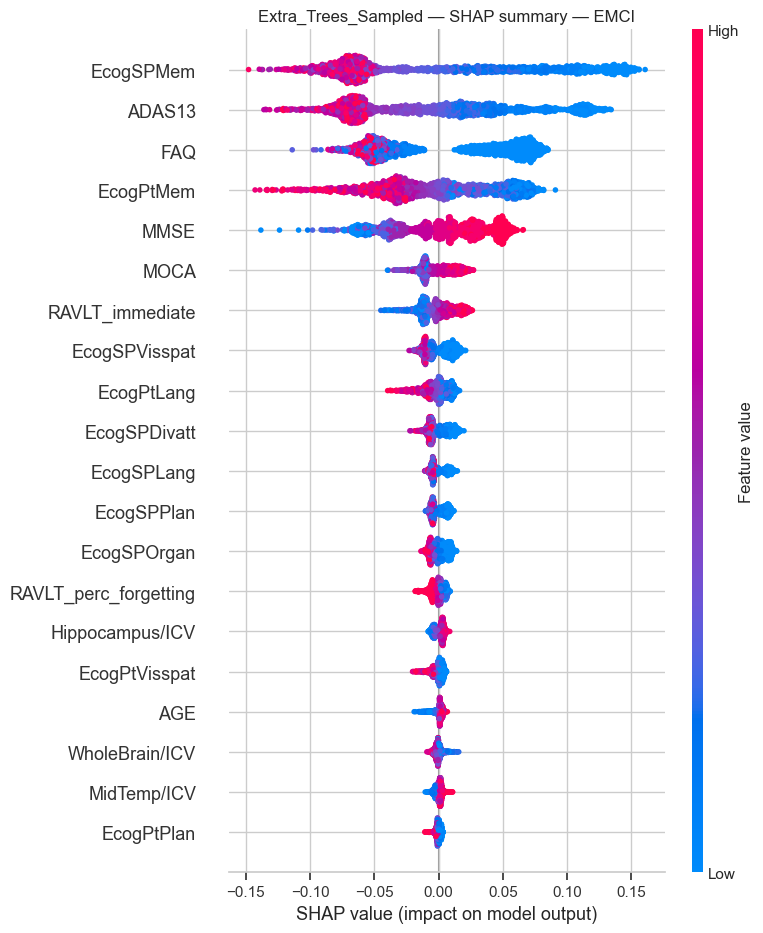

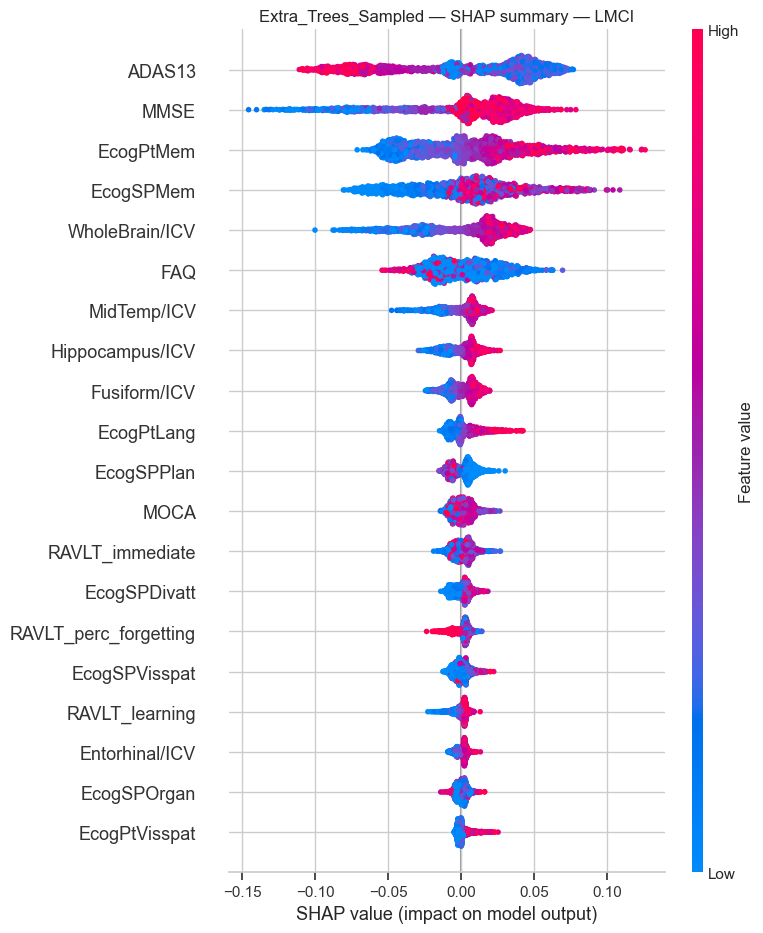

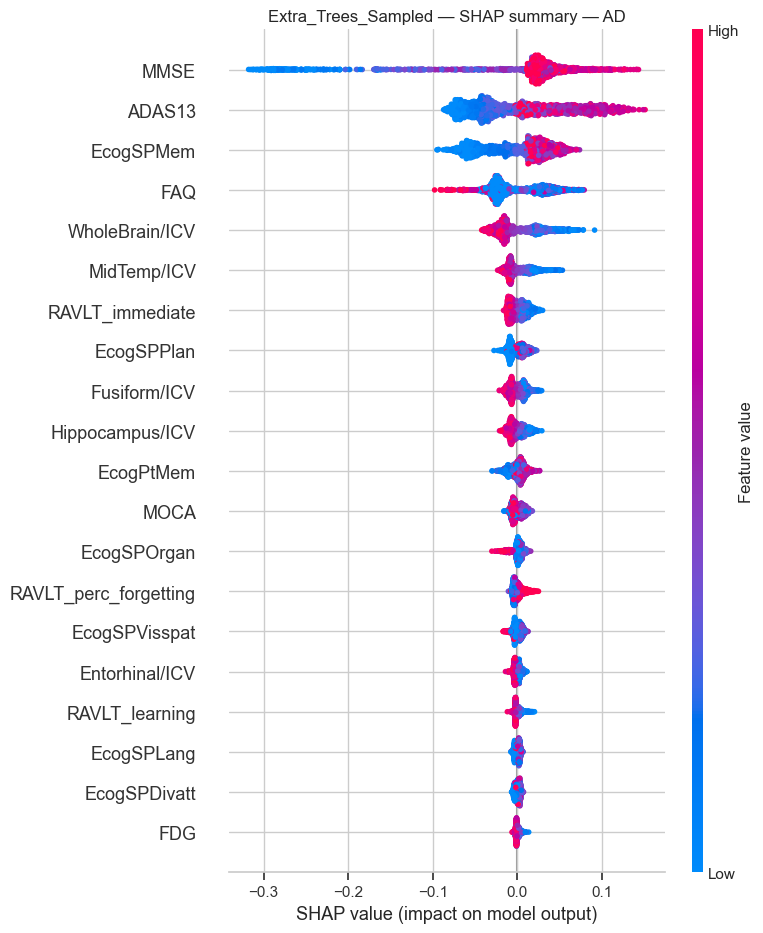

PermutationExplainer explainer: 1935it [01:36, 18.06it/s]                          


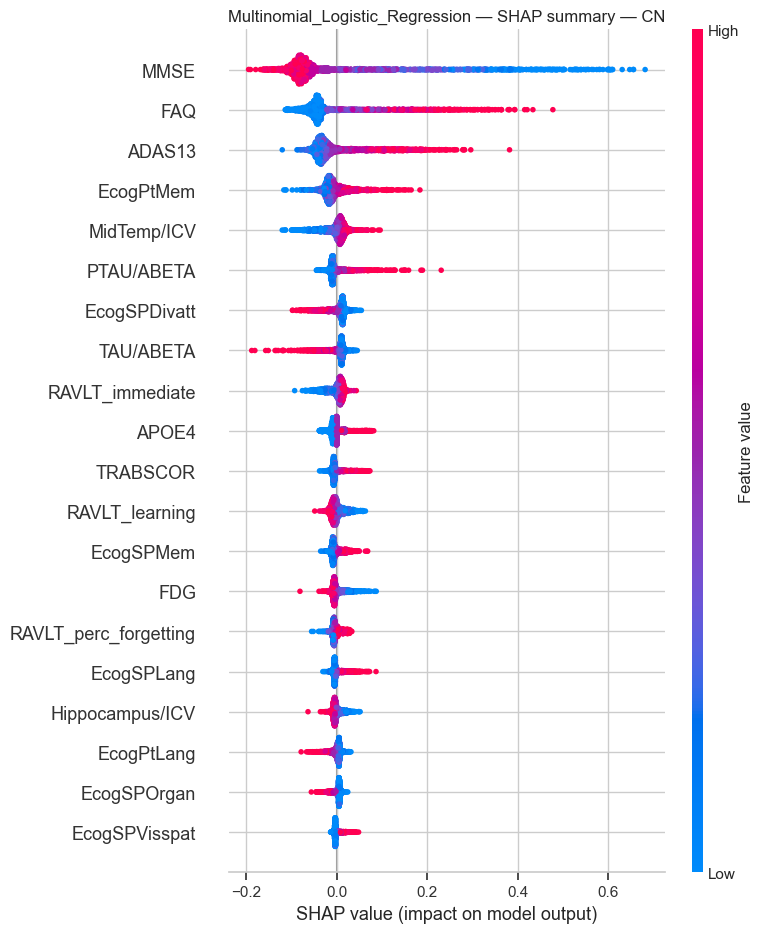

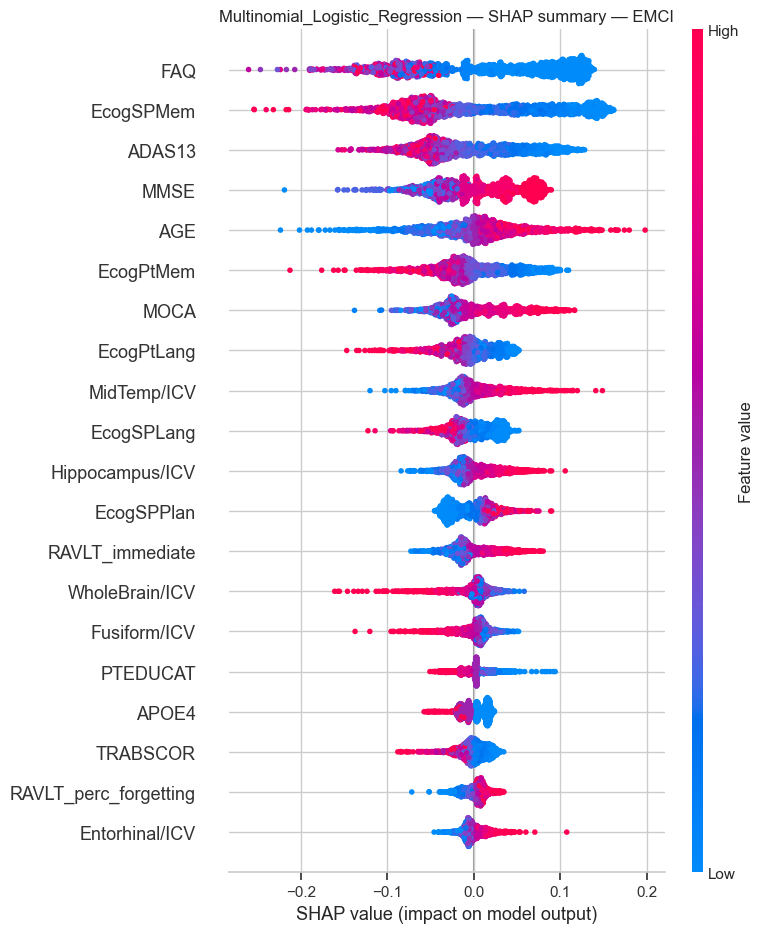

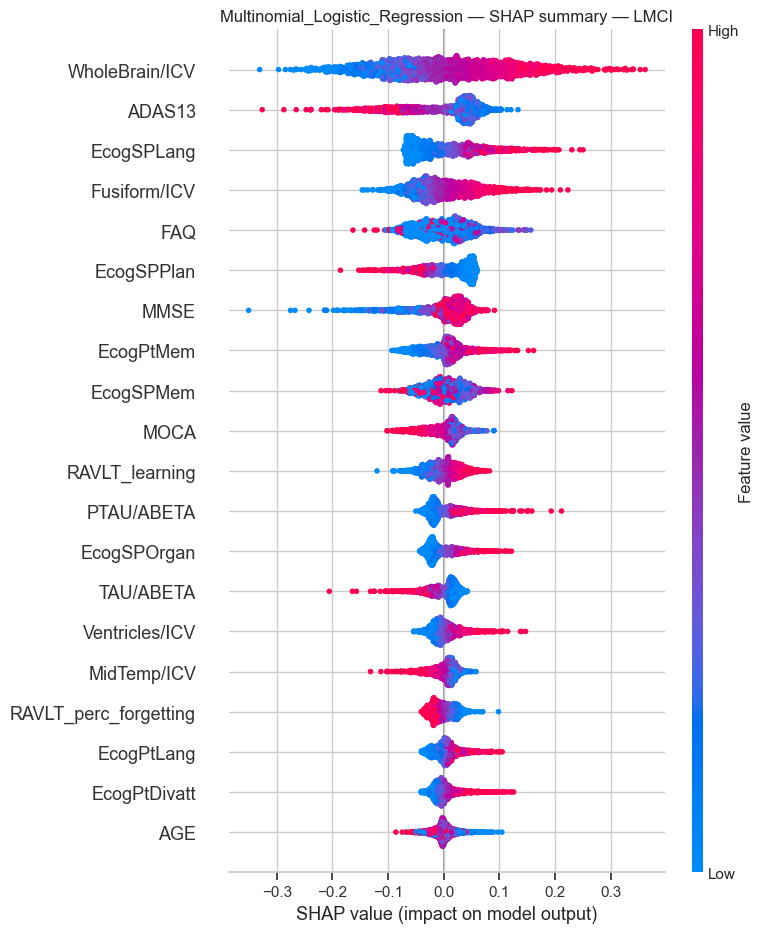

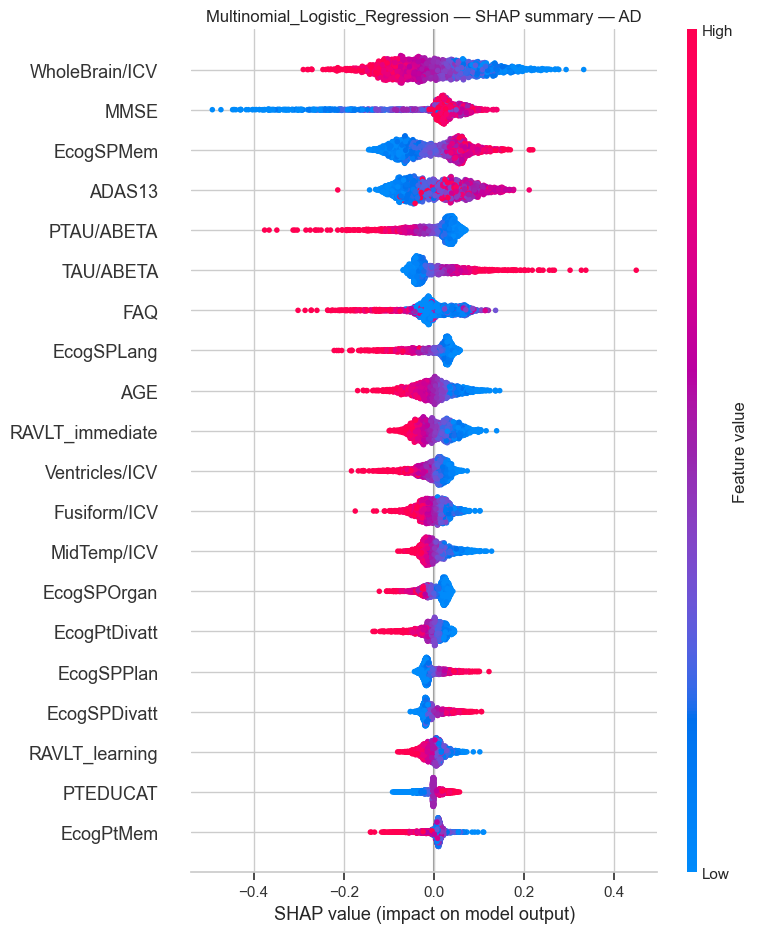

PermutationExplainer explainer: 1935it [01:37, 17.86it/s]                          


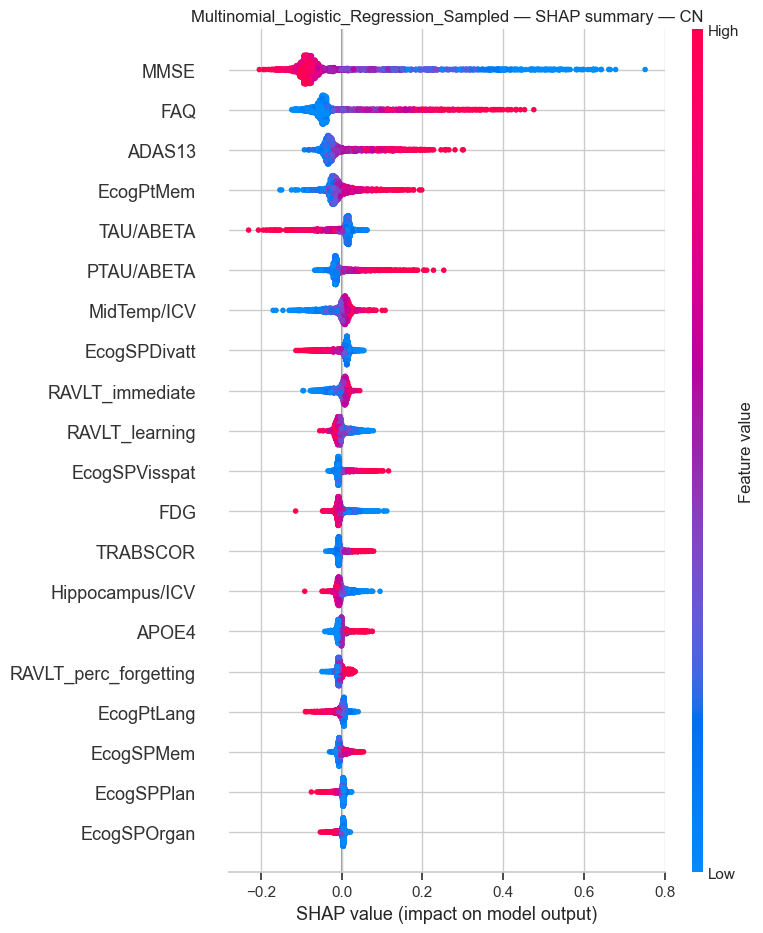

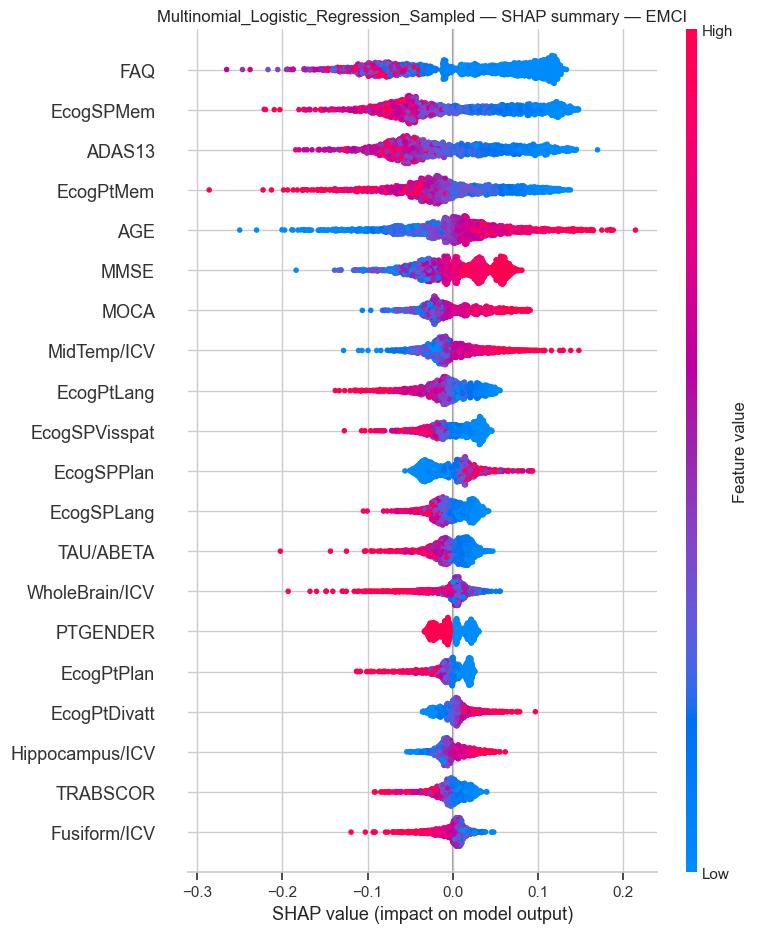

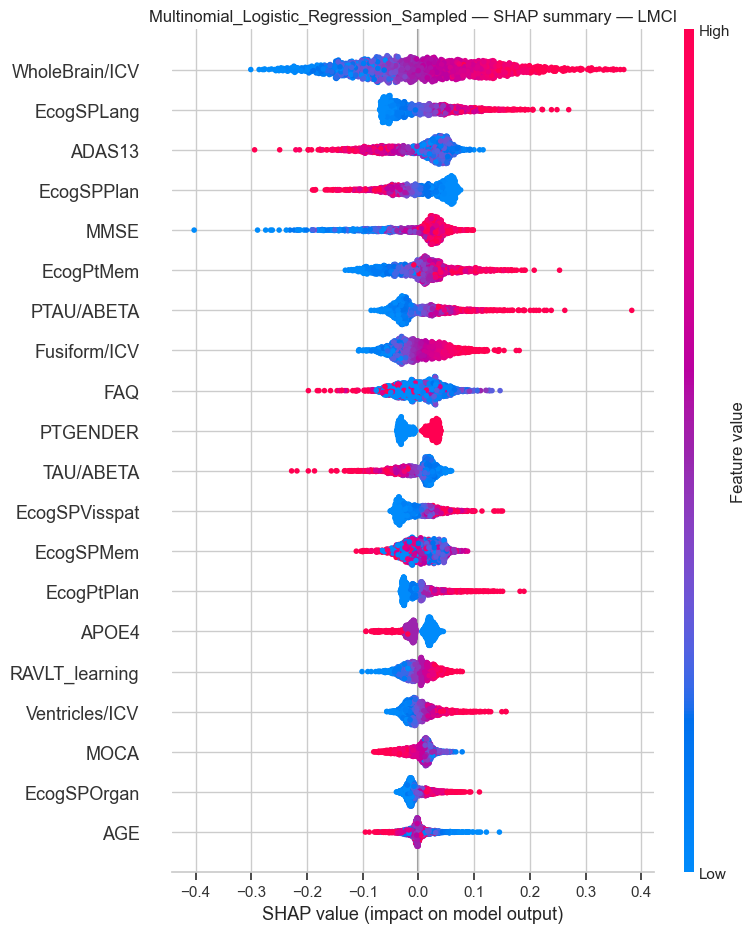

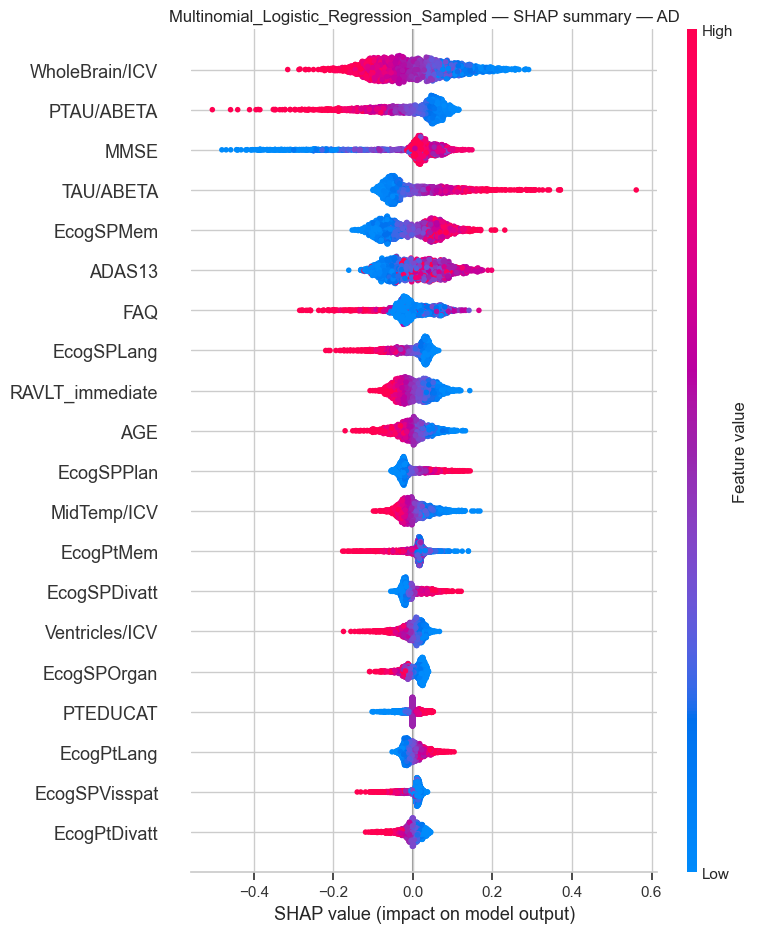

PermutationExplainer explainer: 1935it [14:27,  2.20it/s]                          


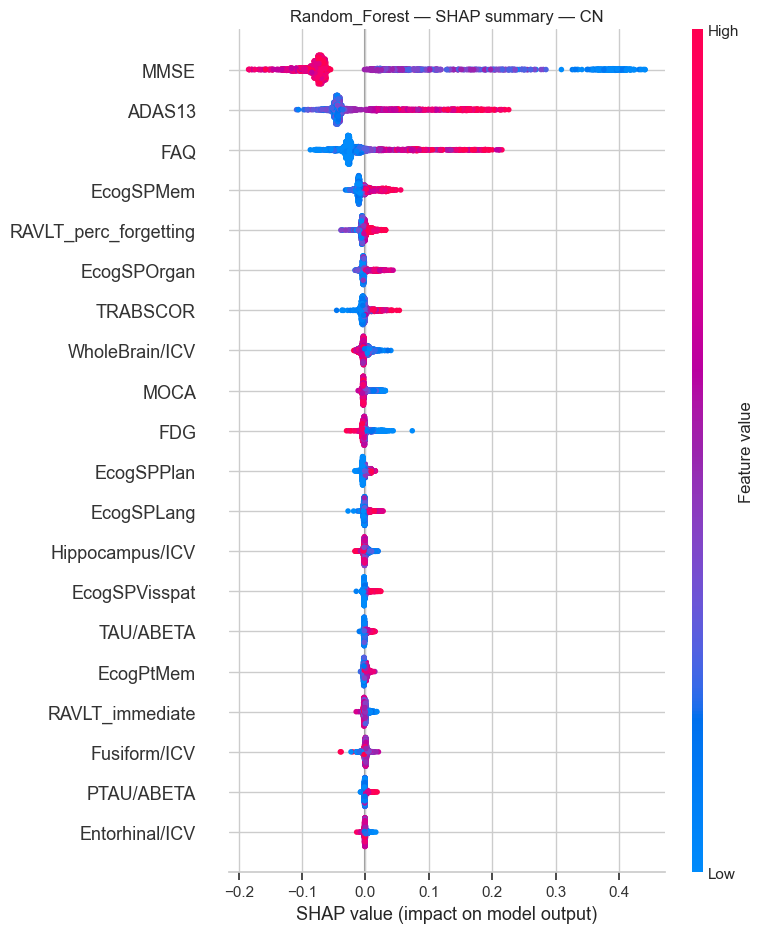

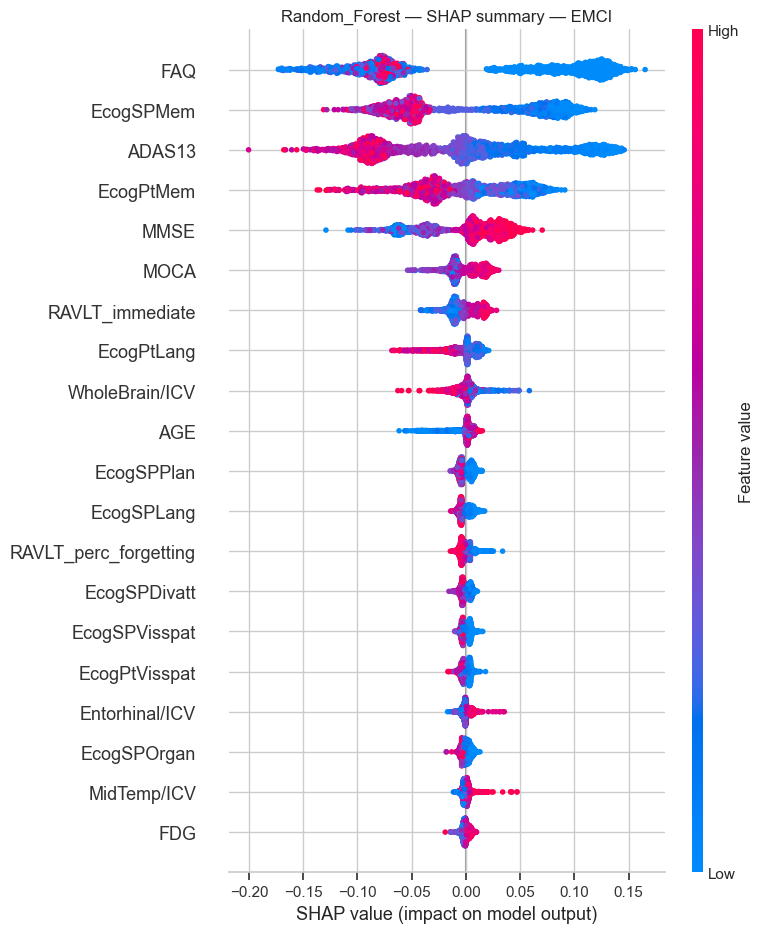

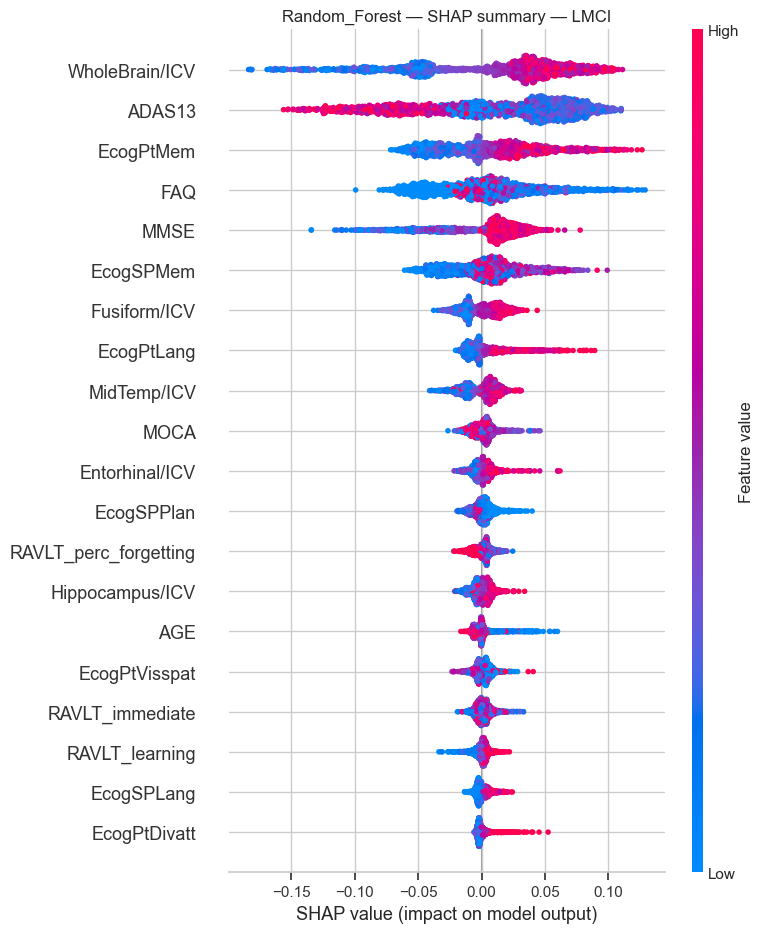

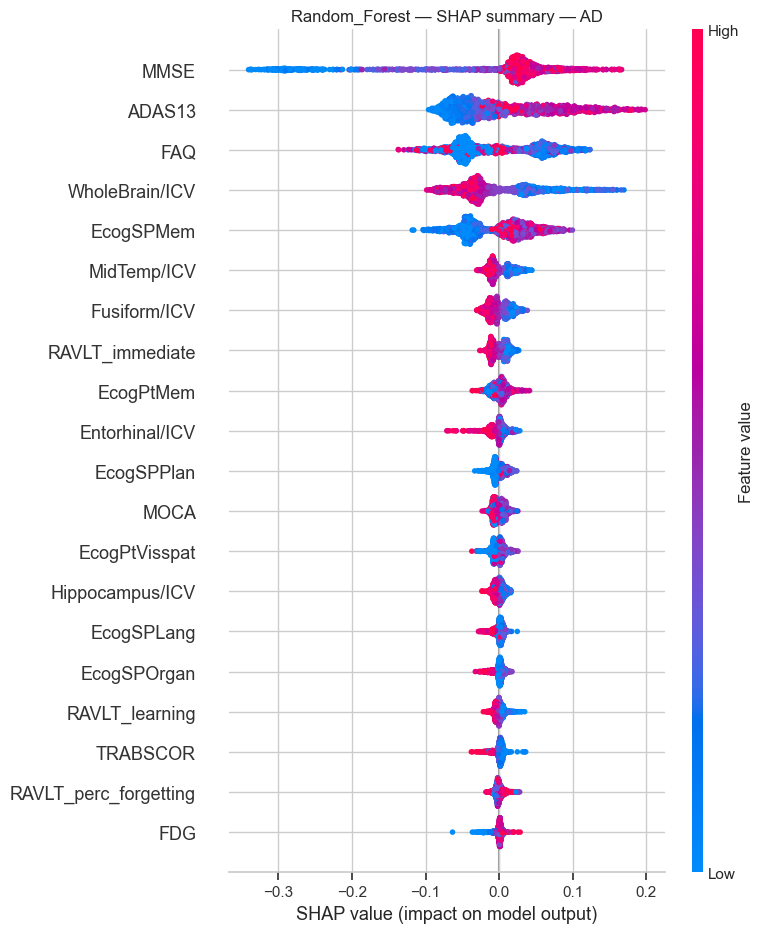

PermutationExplainer explainer: 1935it [14:04,  2.26it/s]                          


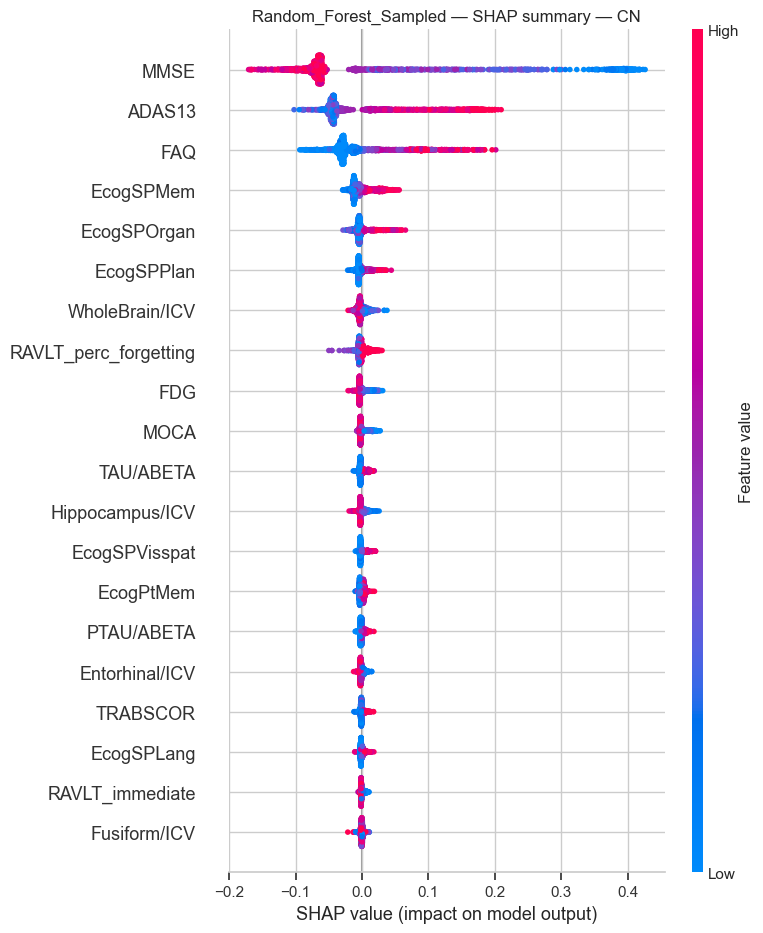

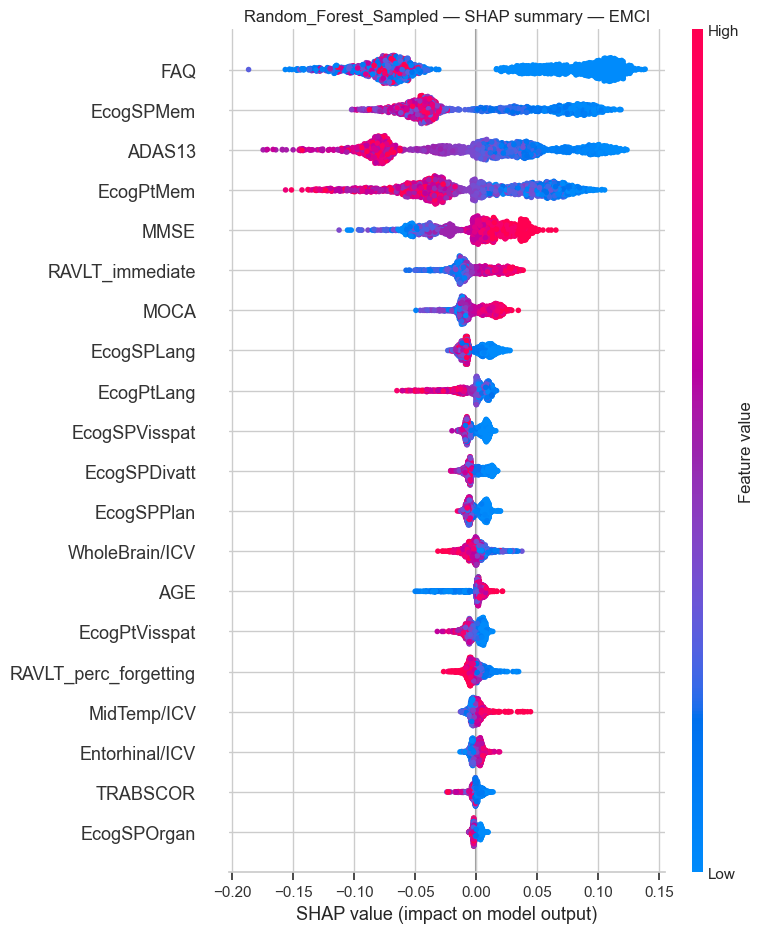

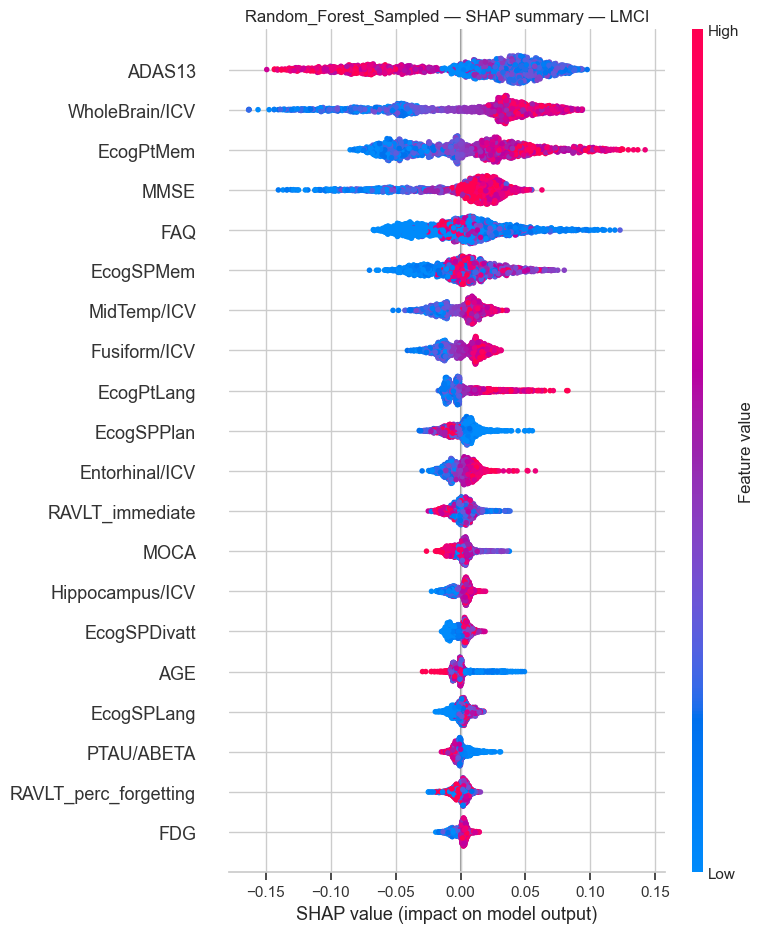

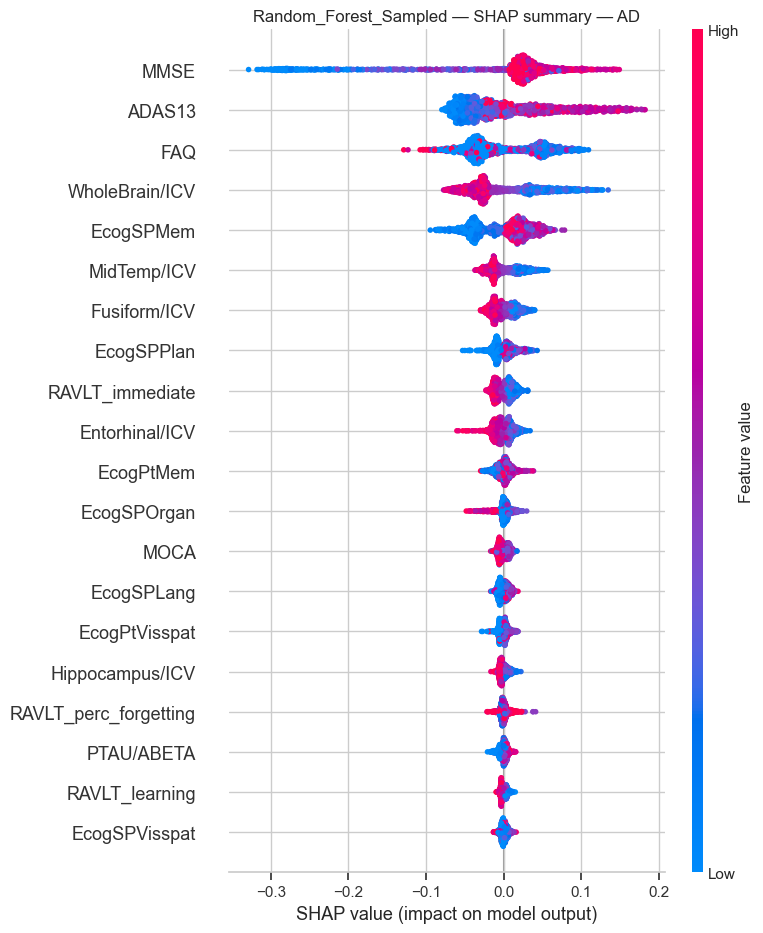

In [20]:
# Load models from folder
models_dir = "../results/all_models/alternative"
models = []

for fname in os.listdir(models_dir):
    if fname.endswith(".pkl"):  
        model_path = os.path.join(models_dir, fname)
        try:
            model = joblib.load(model_path)
            model_name = os.path.splitext(fname)[0]
            models.append((model_name, model))
            print(f"Loaded model: {model_name}")
        except Exception as e:
            print(f"Could not load {fname}: {e}")

# Initialize ModelExplainer
explainer = ModelExplainer(
    models=models,
    X_train=X_train,
    y_train=y_train,
    feature_names=list(X_train.columns),
    class_names=["CN", "EMCI", "LMCI", "AD"],
    random_state=42
)

# Generate SHAP summary plots
explainer.shap_summary_plots()

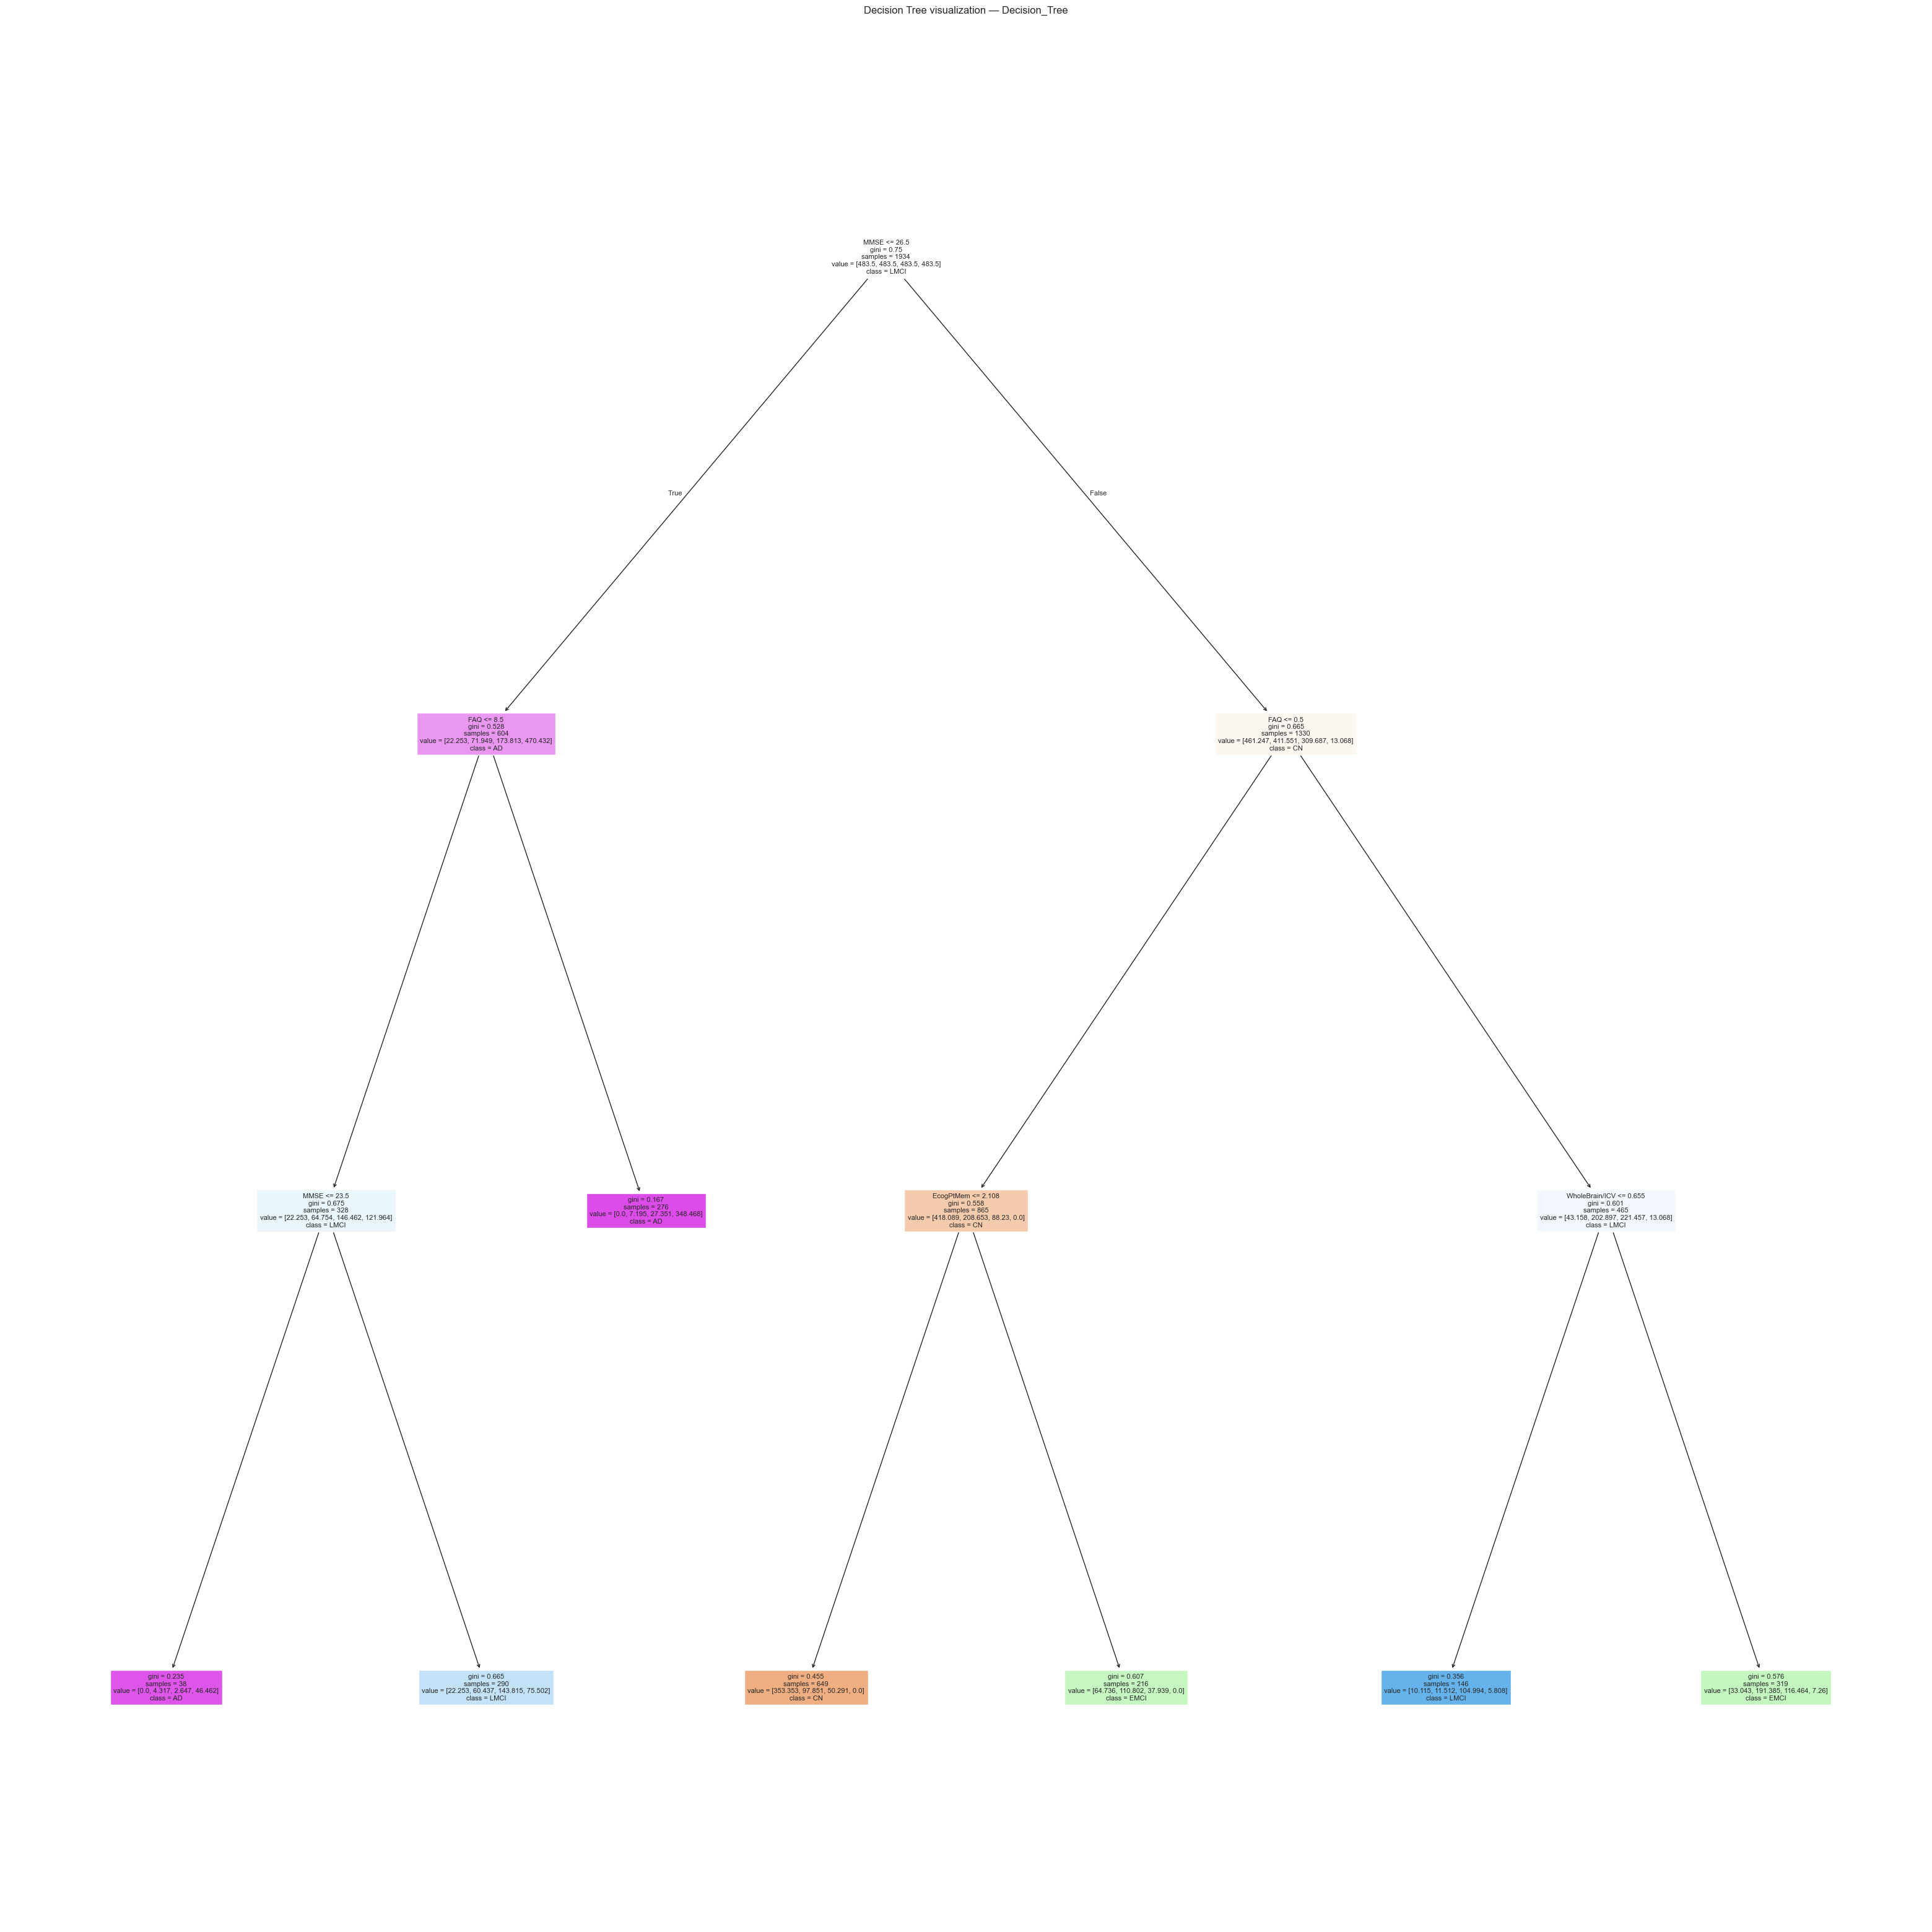

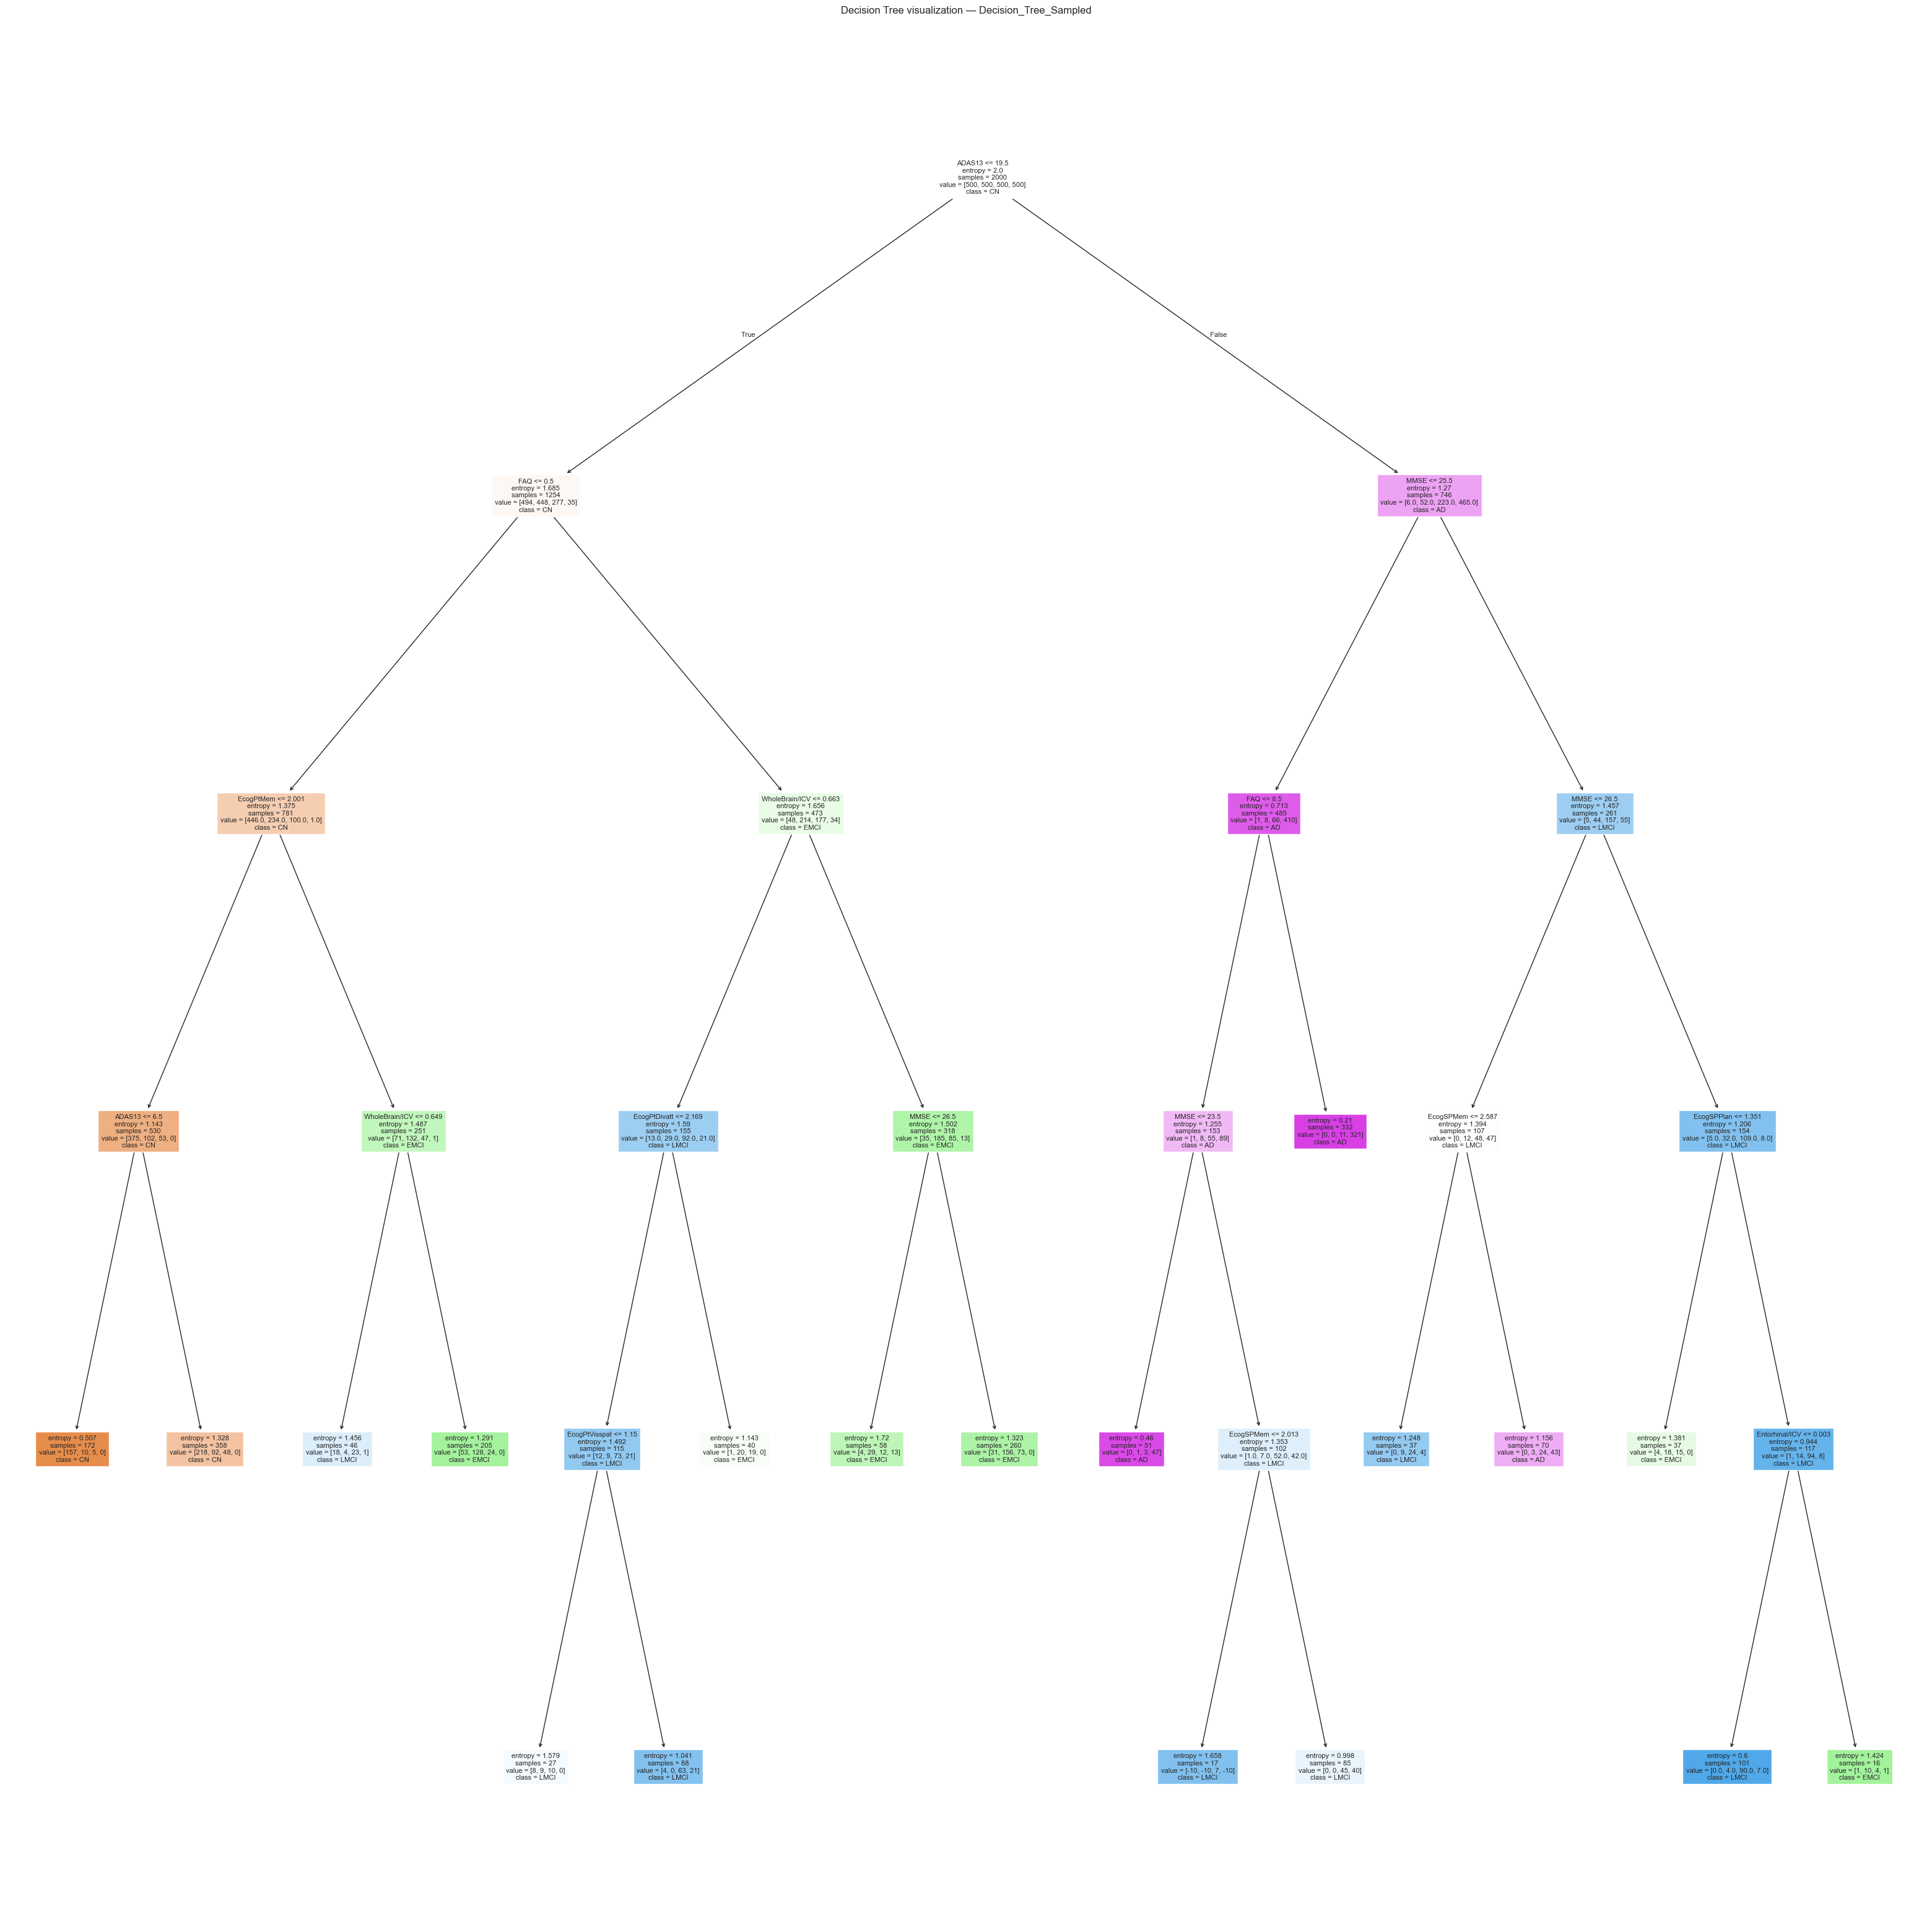

In [21]:
# Generate SHAP summary plot for Decision Tree
explainer.plot_decision_trees(fontsize=8)

Removing  `CDRSB`, `LDELTOTAL`, and `mPACCdigit` produces an immediate and measurable **performance drop**. The **SHAP** plots reveal that, once the dominant trio is removed, the models shift toward a new hierarchy of predictors. The remaining global cognitive and functional measures assume the highest importance. Variables such as `ADAS13`, `MMSE`, `FAQ`, and the **RAVLT** memory scores consistently anchor the top of the SHAP clouds across all classifiers. Their directionality is stable: higher impairment on ADAS or FAQ and lower MMSE scores push the models toward **LMCI** or **AD**, while stronger **RAVLT** performance steers predictions toward **CN**. These signals form the new core of the models’ decision logic, replacing the direct diagnostic severity measures that previously dominated.  However, things are much more balanced now than before with the cognitive trio. Secondary predictors become visibly more influential than before. **MRI-derived** structural ratios (`Hippocampus/ICV`, `Entorhinal/ICV`, `Fusiform/ICV`, and `Ventricles/ICV`), **CSF ratios** (`TAU/ABETA`, `PTAU/ABETA`), and `FDG` PET measures appear throughout the plots with moderate but consistent importance. They do not reach the magnitude of the leading cognitive features but contribute directionally coherent refinements, particularly in intermediate diagnostic regions. 

The **Decision Trees** reflects this restructured landscape. Its top-level splits now rely primarily on global cognitive or functional assessments—typically `ADAS13`, `MMSE`, or `FAQ` (while structural **MRI** ratios and **RAVLT** measures appear only at deeper nodes). The tree remains shallow and decisive, indicating that even without the cognitive trio, a small number of high-purity splits still capture the majority of separability. This yields clear, clinically interpretable decision rules for unequivocal **CN** or **AD** cases but leaves **EMCI** and **LMCI** classifications vulnerable to noise or missingness in the remaining cognitive predictors.

The practical implication of these results is that, once the strongest severity measures are removed, the models depend heavily on the quality and completeness of the remaining cognitive and functional features. Accurate `ADAS`, `MMSE`, `FAQ`, and **RAVLT** assessments become essential. Imaging and biomarker variables contribute meaningfully but cannot compensate fully for degraded cognitive information. Sampling helps distribute attention and reduce single-feature fragility, producing models that generalize more evenly across diagnostic classes, especially **EMCI** and **LMCI**, yet the overall predictive ceiling remains lower than in the original configuration.

## Models Evaluation

In [22]:
pretrain = pd.read_csv("../data/pretrain.csv")
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

# Drop unused columns
pretrain.drop(columns=["CDRSB", "LDELTOTAL", "mPACCdigit"], inplace=True)
train.drop(columns=["CDRSB", "LDELTOTAL", "mPACCdigit"], inplace=True)
test.drop(columns=["CDRSB", "LDELTOTAL", "mPACCdigit"], inplace=True)

# Target column
y_train = train['DX']
y_learn = pretrain['DX'] # The same of y_train
y_test = test['DX']

# All other columns as features
X_train = train.drop(columns=['DX'])
X_learn = pretrain.drop(columns=['DX'])
X_test = test.drop(columns=['DX'])

# Directories with saved .pkl models (you had two directories)
model_dirs = ["../results/all_models/alternative"]

# Preload models at construction time (recommended)
evaluation = ADNIEvaluator(model_dirs=model_dirs, sampling_title=True)

Loaded model 'Adaptive_Boosting' from ../results/all_models/alternative\Adaptive_Boosting.pkl
Loaded model 'Adaptive_Boosting_Sampled' from ../results/all_models/alternative\Adaptive_Boosting_Sampled.pkl
Loaded model 'Decision_Tree' from ../results/all_models/alternative\Decision_Tree.pkl
Loaded model 'Decision_Tree_Sampled' from ../results/all_models/alternative\Decision_Tree_Sampled.pkl
Loaded model 'Extra_Trees' from ../results/all_models/alternative\Extra_Trees.pkl
Loaded model 'Extra_Trees_Sampled' from ../results/all_models/alternative\Extra_Trees_Sampled.pkl
Loaded model 'Multinomial_Logistic_Regression' from ../results/all_models/alternative\Multinomial_Logistic_Regression.pkl
Loaded model 'Multinomial_Logistic_Regression_Sampled' from ../results/all_models/alternative\Multinomial_Logistic_Regression_Sampled.pkl
Loaded model 'Random_Forest' from ../results/all_models/alternative\Random_Forest.pkl
Loaded model 'Random_Forest_Sampled' from ../results/all_models/alternative\Random

**Let's see which of these models performs best on the test set and which one will therefore be chosen.**

Evaluating: Adaptive_Boosting
Evaluating: Adaptive_Boosting_Sampled
Evaluating: Decision_Tree
Evaluating: Decision_Tree_Sampled
Evaluating: Extra_Trees
Evaluating: Extra_Trees_Sampled
Evaluating: Multinomial_Logistic_Regression
Evaluating: Multinomial_Logistic_Regression_Sampled
Evaluating: Random_Forest
Evaluating: Random_Forest_Sampled

F1 Score (macro) per model and split:


Split                                       Train  CrossVal      Test
Model                                                                
Adaptive_Boosting                        0.897984  0.683303  0.730313
Adaptive_Boosting_Sampled                0.842873  0.681983  0.711193
Decision_Tree                            0.668464  0.645751  0.660271
Decision_Tree_Sampled                    0.682010  0.648572  0.648210
Extra_Trees                              0.955794  0.705956  0.699750
Extra_Trees_Sampled                      0.762311  0.694144  0.701107
Multinomial_Logistic_Regression          0.728172  0.696534  0.676843
Multinomial_Logistic_Regression_Sampled  0.725501  0.696534  0.682908
Random_Forest                            0.800159  0.699508  0.706069
Random_Forest_Sampled                    0.784091  0.699237  0.703489

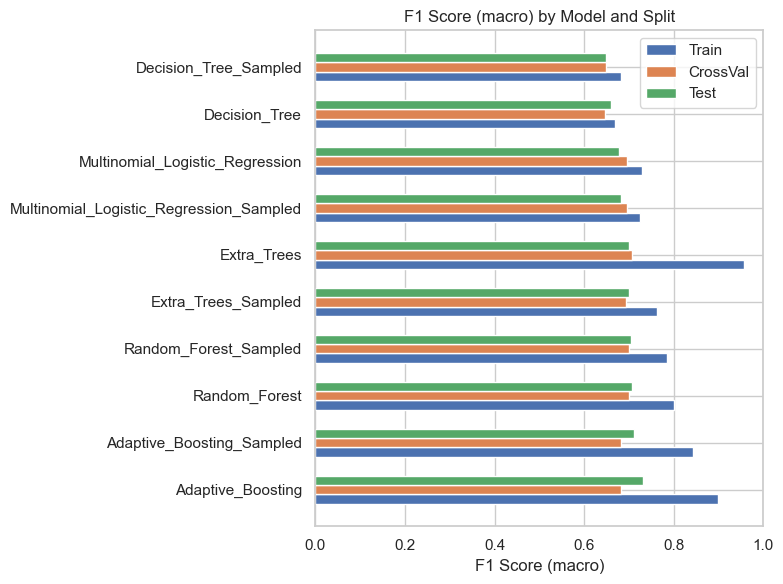


Confusion matrices (raw counts) - TEST SET:


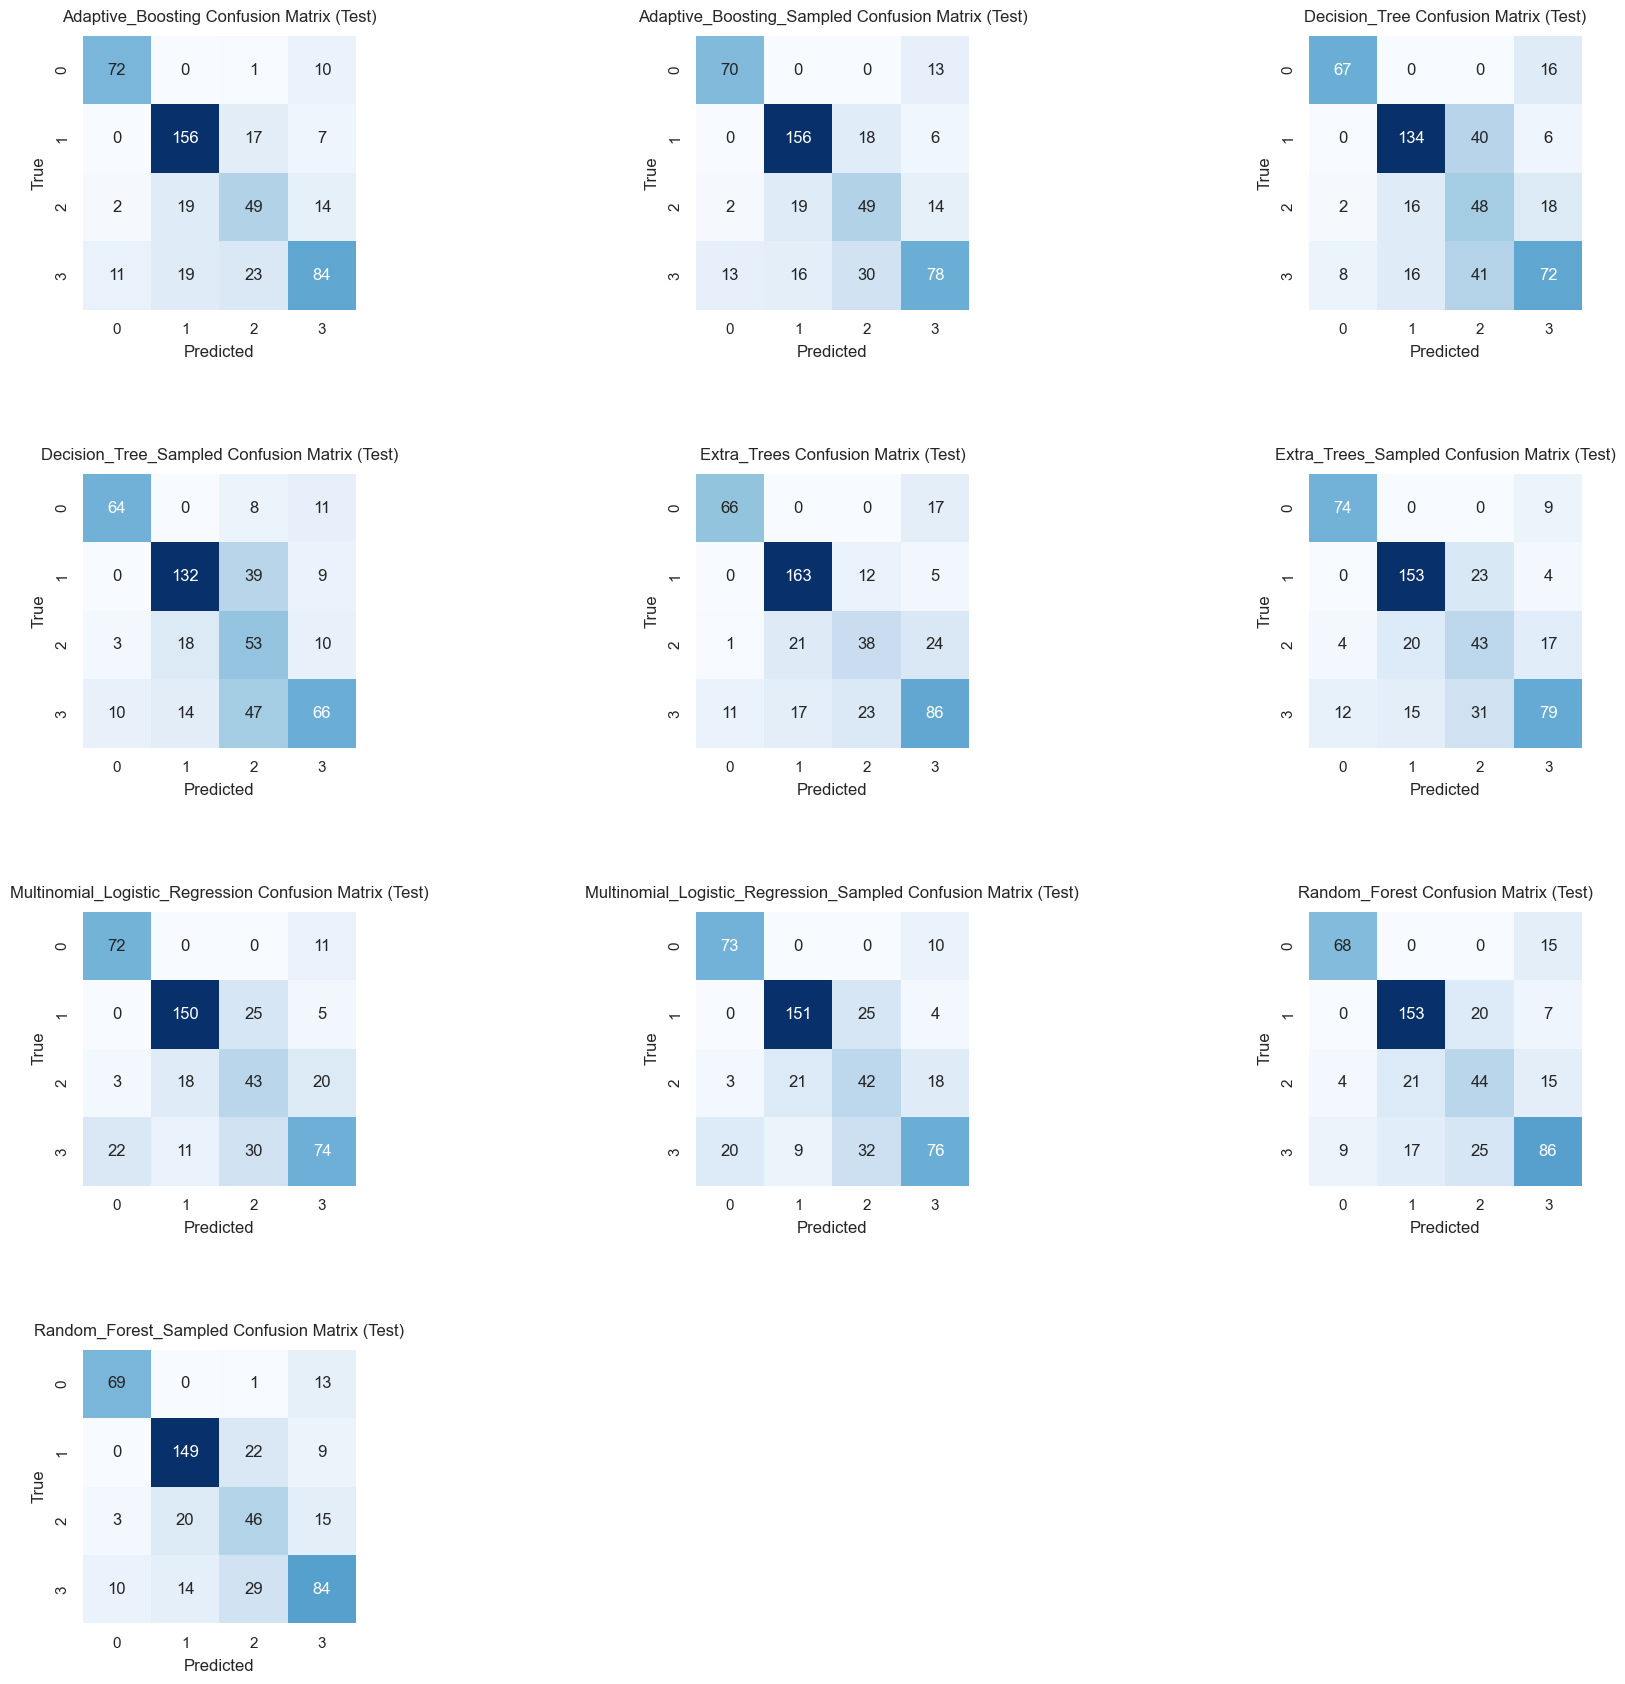


Confusion matrices (normalized by true-row) - TEST SET:


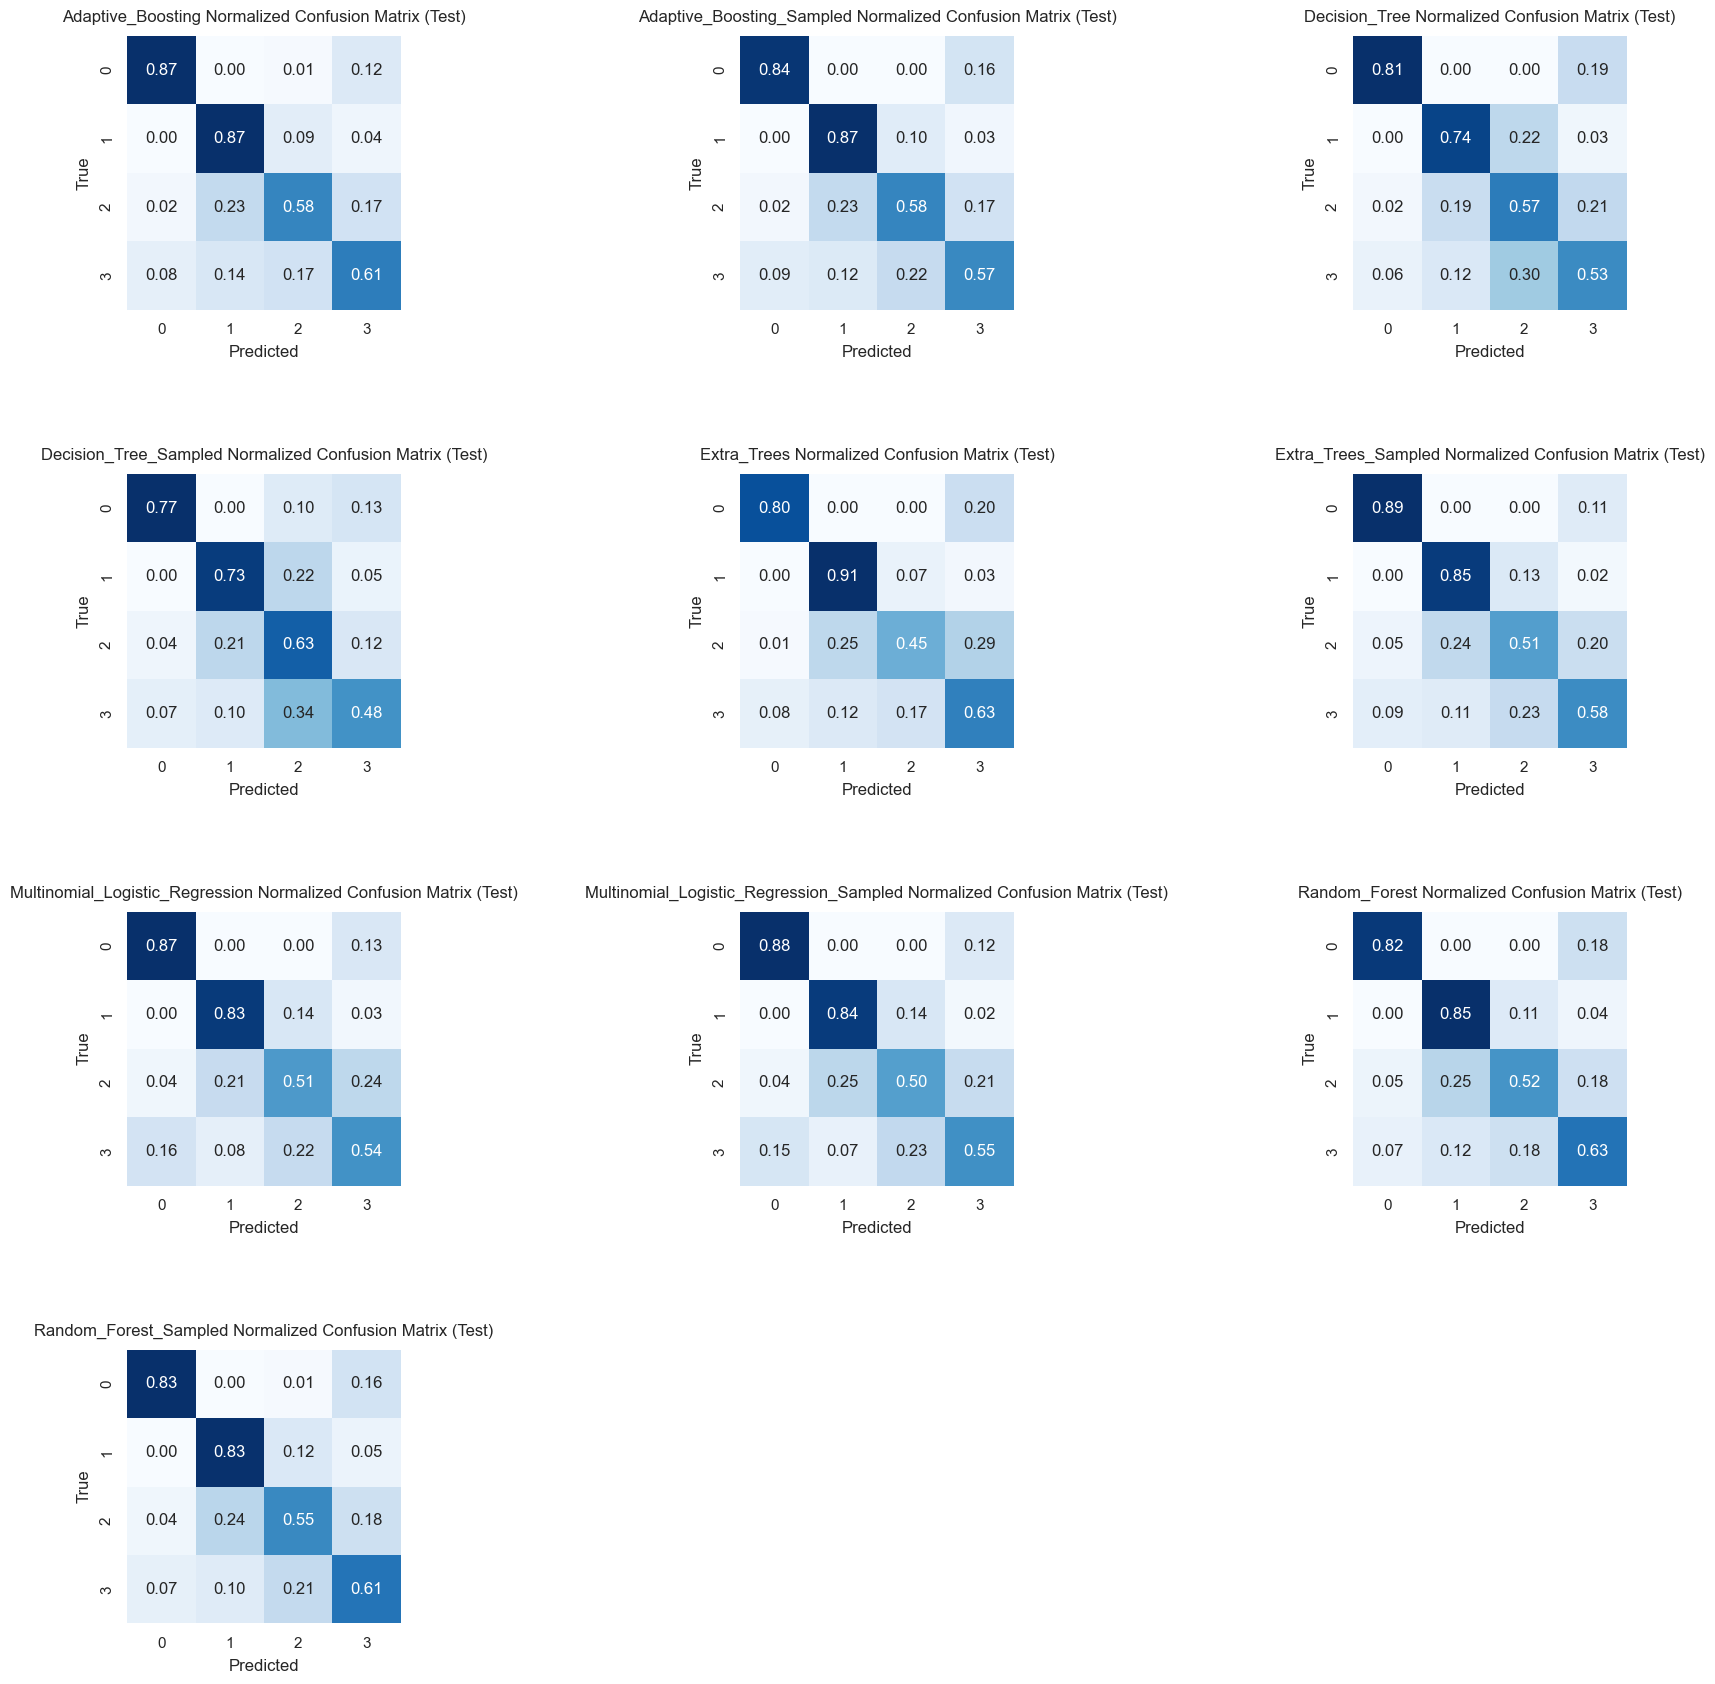

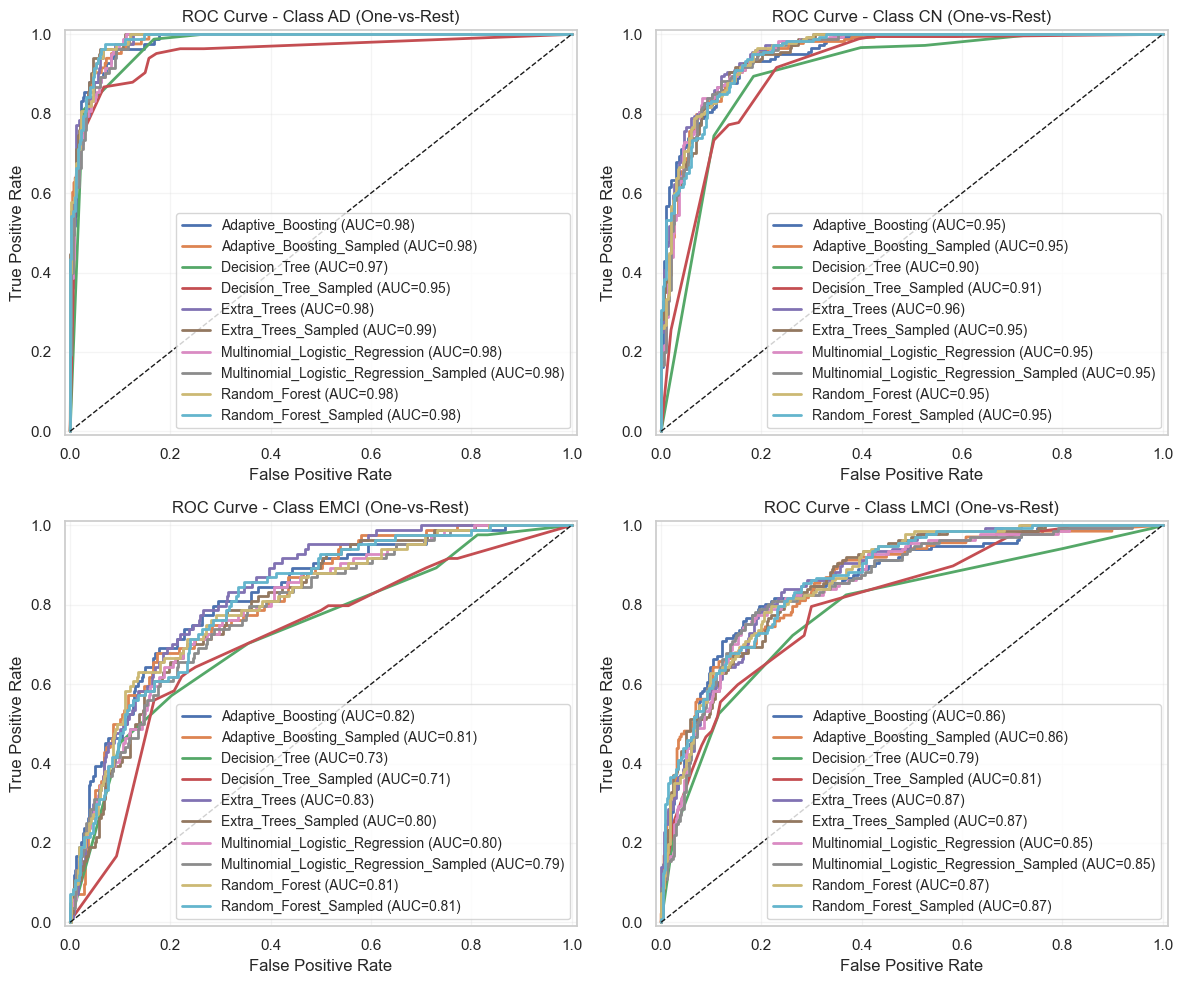


Overall comparison on TEST SET (sorted by F1 Score (macro)):


F1 Score (macro)  Accuracy  \
Model                                                                 
Adaptive_Boosting                                0.730313  0.745868   
Adaptive_Boosting_Sampled                        0.711193  0.729339   
Random_Forest                                    0.706069  0.725207   
Random_Forest_Sampled                            0.703489  0.719008   
Extra_Trees_Sampled                              0.701107  0.721074   
Extra_Trees                                      0.699750  0.729339   
Multinomial_Logistic_Regression_Sampled          0.682908  0.706612   
Multinomial_Logistic_Regression                  0.676843  0.700413   
Decision_Tree                                    0.660271  0.663223   
Decision_Tree_Sampled                            0.648210  0.650826   

                                         Balanced Accuracy  \
Model                                                        
Adaptive_Boosting                                 0.732652   
Adaptive_Boosting_Sampled                         0.715679   
Random_Forest                                     0.705206   
Random_Forest_Sampled                             0.704965   
Extra_Trees_Sampled                               0.707528   
Extra_Trees                                       0.695214   
Multinomial_Logistic_Regression_Sampled           0.693288   
Multinomial_Logistic_Regression                   0.688213   
Decision_Tree                                     0.662162   
Decision_Tree_Sampled                             0.654280   

                                         Precision (weighted)  \
Model                                                           
Adaptive_Boosting                                    0.745560   
Adaptive_Boosting_Sampled                            0.731554   
Random_Forest                                        0.725587   
Random_Forest_Sampled                                0.725072   
Extra_Trees_Sampled                                  0.725753   
Extra_Trees                                          0.721456   
Multinomial_Logistic_Regression_Sampled              0.713480   
Multinomial_Logistic_Regression                      0.705510   
Decision_Tree                                        0.695969   
Decision_Tree_Sampled                                0.699046   

                                         Recall (weighted)  \
Model                                                        
Adaptive_Boosting                                 0.745868   
Adaptive_Boosting_Sampled                         0.729339   
Random_Forest                                     0.725207   
Random_Forest_Sampled                             0.719008   
Extra_Trees_Sampled                               0.721074   
Extra_Trees                                       0.729339   
Multinomial_Logistic_Regression_Sampled           0.706612   
Multinomial_Logistic_Regression                   0.700413   
Decision_Tree                                     0.663223   
Decision_Tree_Sampled                             0.650826   

                                         F1 Score (weighted)  ROC AUC (macro)  
Model                                                                          
Adaptive_Boosting                                   0.743692         0.903667  
Adaptive_Boosting_Sampled                           0.727685         0.900068  
Random_Forest                                       0.724488         0.902221  
Random_Forest_Sampled                               0.720780         0.904075  
Extra_Trees_Sampled                                 0.720213         0.900265  
Extra_Trees                                         0.723815         0.910468  
Multinomial_Logistic_Regression_Sampled             0.706267         0.892135  
Multinomial_Logistic_Regression                     0.699585         0.895152  
Decision_Tree                                       0.673600         0.846666  
Decision_Tree_Sampled                

In [23]:
# Run evaluation
out = evaluation.evaluate_models(
    X_learn=X_learn, y_learn=y_learn,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test,
    cv_splits=5,
    cv_repeats=3,
    display_individual_tables=False,
    plot_roc=True,           # set False if you don't want ROC plots
    save_results_dir=None    # set a path to save test_comparison.csv if you want
)

# "out" is the dictionary returned by evaluate_models
# You can for example inspect the test comparison table
test_comparison_df = out["test_comparison"]

The model with the best overall performance is ***Adaptive Boosting***, which has the highest **F1 Macro** value (0.7303), which is the most suitable metric for evaluating classes in a balanced way. It also has the best **Accuracy** (0.7459) and maintains a very competitive **ROC AUC** macro (0.9037). It will be kept as ***AltModel***. We see that, unlike Cross Validation, the test set gains in predicting **EMCI**, but loses in predicting **AD**. **LMCI** remains a difficult class to predict for these models.

As an explainable model, we use ***Decision Tree*** without sampling, which is better than its version with sampling. It will be referred to as ***AltXAIModel***.

***In summary, we choose ExtraTrees without sampling as "AltModel" and Decision Tree without sampling as "AltXAIModel".*** 

In [24]:
dst_path = "../results"
src_path = "../results/all_models/alternative/Adaptive_Boosting.pkl"
os.makedirs(dst_path, exist_ok=True)
dest_file = os.path.join(dst_path, "AltModel.pkl")
shutil.copy2(src_path, dest_file)

src_path = "../results/all_models/alternative/Decision_Tree.pkl"
os.makedirs(dst_path, exist_ok=True)
dest_file = os.path.join(dst_path, "AltXAIModel.pkl")
shutil.copy2(src_path, dest_file)

src_path = "../results/all_models/alternative/trees/Decision_Tree_tree.pdf"
os.makedirs(dst_path, exist_ok=True)
dest_file = os.path.join(dst_path, "AltXAIModel_tree.pdf")
shutil.copy2(src_path, dest_file)

src_path = "../results/all_models/alternative/rules/Decision_Tree_rules.txt"
os.makedirs(dst_path, exist_ok=True)
dest_file = os.path.join(dst_path, "AltXAIModel_rules.txt")
shutil.copy2(src_path, dest_file)

print("Saved Models: AltModel, AltXAIModel")

Saved Models: AltModel, AltXAIModel
